## Цель работы

Есть небольшой тестовый датасет с данными о машинах, их признаках и стоимости. Необходимо проанализировать датасет, а также собрать данные для обучения, провести разведывательный анализ и построить модель для предсказания стоимости на тестовом датасете. Качество модели предлагается измерять с помощью метрики MAPE. Данная задача является задачей регрессии.

## Импорт библиотек

Импортируем библиотеки, которые понадобятся в ходе анализа данных. Остальные будут добавляться по мере надобности, в зависимости от результатов анализа.

In [302]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

import warnings
import json
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

%matplotlib inline

## Вспомогательные функции

In [303]:
# функция для нахождения значимых различий для признака по тесту Стьюдента
def get_stat_dif(column):
    cols = df_train.loc[:, column].value_counts().index[:10]
    has_importance = False
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df_train.loc[df_train.loc[:, column] == comb[0], 'price'],
                     df_train.loc[df_train.loc[:, column] == comb[1], 'price']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            has_importance = True
            print('Найдены статистически значимые различия для колонки', column)
            break
    if not has_importance:
        print('Статистически значимых различий для колонки {} не найдено'.format(column))


# функция отрисовки боксплота для конкретной колонки
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='price',
                data=df_train.loc[df_train.loc[:, column].isin(
                    df_train.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


# функция для проверки на выбросы
def check_for_outliers(column, bins_number):
    median = df_train[column].median()
    IQR = df_train[column].quantile(0.75) - df_train[column].quantile(0.25)
    perc25 = df_train[column].quantile(0.25)
    perc75 = df_train[column].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    df_train[column].loc[df_train[column].between(
        perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins=bins_number, label='IQR')
    plt.legend()

## Изучение датасетов, вычищение данных и приведение их к единому формату

Датасет для обучения был взят с kaggle по ссылке https://www.kaggle.com/macsunmood/autoru-parsed-0603-1304

In [304]:
df_train = pd.read_csv('train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109080 entries, 0 to 109079
Data columns (total 22 columns):
Unnamed: 0              109080 non-null int64
bodyType                109079 non-null object
brand                   109080 non-null object
color                   109080 non-null object
fuelType                109080 non-null object
modelDate               109079 non-null float64
name                    109079 non-null object
numberOfDoors           109079 non-null float64
productionDate          109080 non-null int64
vehicleConfiguration    109079 non-null object
engineDisplacement      109079 non-null object
enginePower             109079 non-null float64
description             105829 non-null object
mileage                 109080 non-null int64
Комплектация            109080 non-null object
Привод                  109079 non-null object
Руль                    109080 non-null object
Владельцы               109073 non-null float64
ПТС                     109078 non-null ob

Посмотрим, сколько пропусков в столбцах.

In [305]:
df_train.isna().sum().sort_values(ascending=False)

Владение                69191
description              3251
Владельцы                   7
ПТС                         2
engineDisplacement          1
name                        1
bodyType                    1
Привод                      1
enginePower                 1
vehicleConfiguration        1
modelDate                   1
numberOfDoors               1
brand                       0
color                       0
fuelType                    0
Price                       0
productionDate              0
mileage                     0
Комплектация                0
Руль                        0
Таможня                     0
Unnamed: 0                  0
dtype: int64

Больше всего у нас пропусков в признаках "Владение", "description". В остальных столбцах пропусков совсем немного или вовсе нет.

In [306]:
df_test = pd.read_csv('test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 23 columns):
bodyType                3837 non-null object
brand                   3837 non-null object
color                   3837 non-null object
fuelType                3837 non-null object
modelDate               3837 non-null float64
name                    3837 non-null object
numberOfDoors           3837 non-null float64
productionDate          3837 non-null float64
vehicleConfiguration    3837 non-null object
vehicleTransmission     3837 non-null object
engineDisplacement      3837 non-null object
enginePower             3837 non-null object
description             3837 non-null object
mileage                 3837 non-null float64
Комплектация            3837 non-null object
Привод                  3837 non-null object
Руль                    3837 non-null object
Состояние               3837 non-null object
Владельцы               3837 non-null object
ПТС                     3837 non-n

In [307]:
df_test.isna().sum().sort_values(ascending=False)

Владение                2084
id                         0
engineDisplacement         0
brand                      0
color                      0
fuelType                   0
modelDate                  0
name                       0
numberOfDoors              0
productionDate             0
vehicleConfiguration       0
vehicleTransmission        0
enginePower                0
description                0
mileage                    0
Комплектация               0
Привод                     0
Руль                       0
Состояние                  0
Владельцы                  0
ПТС                        0
Таможня                    0
bodyType                   0
dtype: int64

В тестовом датасете у нас всего 1 столбец с пропусками. Пропусков больше половины, и скорее всего, этот столбец не будет нам нужен.

Далее приведем названия колонок в обоих датасетах к единообразному виду.

In [308]:
df_train.columns = ['id', 'body_type', 'brand', 'color', 'fuel_type', 'model_date', 'name',
                    'doors_number', 'production_date', 'vehicle_configuration',
                    'engine_displacement', 'engine_power', 'description', 'mileage', 'complectation',
                    'drive_type', 'steering_wheel', 'owners', 'technical_passport',
                    'customs', 'ownership', 'price']

df_test.columns = ['body_type', 'brand', 'color', 'fuel_type', 'model_date', 'name',
                   'doors_number', 'production_date', 'vehicle_configuration', 'vehicle_transmission',
                   'engine_displacement', 'engine_power', 'description', 'mileage', 'complectation',
                   'drive_type', 'steering_wheel', 'condition', 'owners', 'technical_passport',
                   'customs', 'ownership', 'id']

Сразу удалим столбцы ownership (как имеющий множество пропусков) и description (не несет в себе особой смысловой нагрузки).

In [309]:
df_train = df_train.drop(columns=['ownership', 'description'], axis=1)
df_test = df_test.drop(columns=['ownership', 'description'], axis=1)

Сразу отметим, что в тренировочном датасете есть целевая переменная **price**, которой нет в тестовом датасете. В тестовом датасете также есть признаки **condition и vehicle_transmission**, которых нет в тренировочном датасете.

In [310]:
display(df_train.head(1))
display(df_test.head(1))

,id,body_type,brand,color,fuel_type,model_date,name,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,steering_wheel,owners,technical_passport,customs,price
0,0,Седан,AUDI,040001,бензин,1990.0,2.3 MT (133 л.с.),4.0,1991,MECHANICAL,2.3,133.0,10000,{'id': '0'},передний,LEFT,3.0,ORIGINAL,True,135000


,body_type,brand,color,fuel_type,model_date,name,doors_number,production_date,vehicle_configuration,vehicle_transmission,engine_displacement,engine_power,mileage,complectation,drive_type,steering_wheel,condition,owners,technical_passport,customs,id
0,седан,BMW,чёрный,дизель,2016.0,520d 2.0d AT (190 л.с.),4.0,2017.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,190 N12,158836.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,0


Видно, что в тестовом датасете vehicle_transmission - это то, что находится в тренировочном датасете в столбце vehicle_configuration. Поэтому сразу заменим значения на соответствующие тренировочному датасету и удалим заведомо лишние столбцы.

In [311]:
df_test['vehicle_configuration'] = df_test['vehicle_transmission']

df_test.drop(columns=['vehicle_transmission',
                      'condition', 'id'], axis=1, inplace=True)
df_train.drop(columns=['id'], axis=1, inplace=True)

Теперь у нас одинаковая структура в обоих датасетах. Добавим столбец price, заполненный нулями, в тестовый датасет.

In [312]:
df_test['price'] = 0

Посмотрим на количество уникальных значений в тестовых данных.

In [313]:
df_test.nunique()

body_type                  11
brand                       1
color                      15
fuel_type                   4
model_date                 31
name                      384
doors_number                4
production_date            37
vehicle_configuration       3
engine_displacement        22
engine_power               75
mileage                  1942
complectation            3295
drive_type                  3
steering_wheel              1
owners                      3
technical_passport          2
customs                     1
price                       1
dtype: int64

Видно, что в тестовом датасете представлены данные всего лишь по одному бренду. Посмотрим, что это за бренд, и сколько данных по этому бренду в обучающем датасете.

In [314]:
df_test['brand'].unique()

array(['BMW'], dtype=object)

In [315]:
df_train[df_train['brand'] == 'BMW'].shape

(14390, 19)

Получилось 14390 значений, скорее всего, этого будет вполне достаточно. Отфильтруем обучающий датасет, оставив данные только о бренде BMW.

In [316]:
df_train = df_train[df_train['brand'] == 'BMW']

Теперь объединим датасеты для удобства работы с данными. Столбец brand теперь мы можем также удалить.

In [317]:
df = pd.concat([df_train, df_test], ignore_index=True)
df.shape

(18227, 19)

In [318]:
df = df.drop(columns=['brand'], axis=1)

### Работа с полем body_type

In [319]:
df['body_type'].value_counts(dropna=False)

Внедорожник 5 дв.         5842
Седан                     5687
внедорожник 5 дв.         1626
седан                     1594
Купе                       707
Седан Long                 664
Хэтчбек 5 дв.              583
Лифтбек Gran Turismo       342
купе                       214
Универсал 5 дв.            164
хэтчбек 5 дв.              163
Хэтчбек 3 дв.              154
лифтбек                    125
Кабриолет                   70
Седан Gran Coupe            50
универсал 5 дв.             46
хэтчбек 3 дв.               36
Родстер                     33
Лифтбек Gran Coupe          32
Хэтчбек 3 дв. Compact       25
кабриолет                   19
Компактвэн Gran Tourer      15
Седан 2 дв.                 12
родстер                     10
Родстер Roadster             4
Компактвэн                   4
компактвэн                   3
Купе-хардтоп                 2
седан 2 дв.                  1
Name: body_type, dtype: int64

Это категориальный (номинативный) признак. Так как количество дверей прописано отдельно, оставим только первое слово, обозначающее базовую классификацию, и приведем все к единому виду (lowercase).

In [320]:
# функция для вычищения данных по признаку body_type
def clean_body_type(value):
    if value == value:
        index_space = value.find(' ')
        index_def = value.find('-')
        if index_space == -1 and index_def == -1:
            return value.lower()
        if index_space != -1 and index_def == -1:
            return value[:index_space].lower()
        if index_def != -1 and index_space == -1:
            return value[:index_def].lower()
        if index_def != -1 and index_space != -1:
            return value[:min(index_def, index_space)].lower()
    else:
        return value


df['body_type'] = df['body_type'].apply(clean_body_type)
display(df['body_type'].value_counts(dropna=False))

седан          8008
внедорожник    7468
хэтчбек         961
купе            923
лифтбек         499
универсал       210
кабриолет        89
родстер          47
компактвэн       22
Name: body_type, dtype: int64

Далее объединим минивэн, компактвэн и микровэн в один класс, так как это внутренние разновидности минивэна. Также объединим хэтчбэк и лифтбэк в один класс. И также объединим открытые типы кузова (кабриолет, родстер, тарга) в класс "открытый", для сокращения количества значений.

In [321]:
def replace_body_type(value):
    if value in ['минивэн', 'компактвэн', 'микровэн']:
        return 'минивэн'
    if value in ['хэтчбек', 'лифтбек']:
        return 'хэтчбек'
    if value in ['родстер', 'кабриолет', 'тарга']:
        return 'открытый'
    return value


df['body_type'] = df['body_type'].apply(replace_body_type)
df['body_type'].value_counts(dropna=False)

седан          8008
внедорожник    7468
хэтчбек        1460
купе            923
универсал       210
открытый        136
минивэн          22
Name: body_type, dtype: int64

Теперь посмотрим на распределение значений признака на тренировочном датасете, а также проверим признак на наличие значимых статистических различий по тесту Стьюдента.

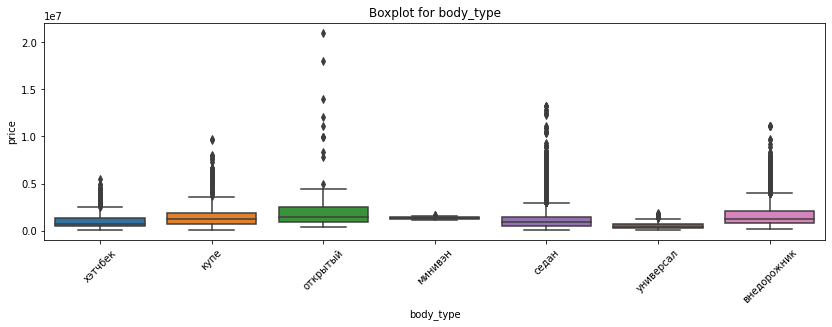

Найдены статистически значимые различия для колонки body_type


In [322]:
df_train = df[df.price != 0]
get_boxplot('body_type')
get_stat_dif('body_type')

### Работа с полем color

In [323]:
df['color'].value_counts(dropna=False)

040001         5560
FAFBFB         2656
0000CC         1858
97948F         1587
чёрный         1395
CACECB          855
белый           767
200204          747
синий           510
серый           453
EE1D19          419
коричневый      216
серебристый     191
007F00          168
C49648          163
22A0F8          156
красный         115
660099           72
FF8649           53
DEA522           48
бежевый          46
голубой          35
зелёный          33
4A2197           32
оранжевый        27
золотистый       23
пурпурный        20
FFD600           16
фиолетовый        5
жёлтый            1
Name: color, dtype: int64

В признаке цвета машины пропусков тоже нет, это категориальный (номинативный) признак. Всего здесь 30 значений. Составим словарь отображения цветов на русском в кода, а потом единообразно обработаем цветовые кода и приведем их к английским цветам. Для определения названия цвета кода будем использовать цветовую палитру matplotlib.colors.

In [324]:
import matplotlib.colors as mc
# используем палитру цветов matplotlib
mycss4list = mc.CSS4_COLORS

# коды для встречающихся русскоязычных названий цветов взяты из Википедии
colors = {
    'чёрный': '000000', 'белый': 'FFFFFF', 'синий': '0000FF', 'серый': '808080',
    'коричневый': 'A52A2A', 'серебристый': 'C0C0C0', 'красный': 'FF0000', 'бежевый': 'F5F5DC',
    'голубой': '75BBFD', 'зелёный': '008000', 'оранжевый': 'FFA500', 'золотистый': 'FFD700',
    'пурпурный': '800080', 'фиолетовый': '8B00FF', 'жёлтый': 'FFFF00'
}


def hex_to_rgb(value):
    # в словаре matplotlib первый символ - решетка, поэтому его не обрабатываем
    if value[0] == '#':
        return tuple(int(value[i:i+2], 16) for i in (1, 3, 5))
    # в нашем датасете решетки в названиях нет
    else:
        return tuple(int(value[i:i+2], 16) for i in (0, 2, 4))


# получение имени ближайшего цвета
def closest_colour(requested_colour):
    min_colours = {}
    # вычисление Евклидовых расстояний между искомым цветом и палитрой matplotlib
    for name, key in mycss4list.items():
        red, green, blue = hex_to_rgb(key)
        rd = (red - requested_colour[0]) ** 2
        gd = (green - requested_colour[1]) ** 2
        bd = (blue - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    # возвращаем название цвета с наименьшим расстоянием до искомого
    return min_colours[min(min_colours.keys())]


def get_colour_name(value):
    if value == value:
        hex_value = value
        if value in colors.keys():
            hex_value = colors[value]
        rgb_value = hex_to_rgb(hex_value)
        closest_name = closest_colour(rgb_value)
        return closest_name
    else:
        return value


unique_colors = df['color'].unique()

color_dict = {}

for color in unique_colors:
    color_dict[color] = get_colour_name(color)

df['color'] = df['color'].apply(lambda x: color_dict[x])

In [325]:
df['color'].value_counts(dropna=False)

black            7702
snow             2656
grey             2040
mediumblue       1858
lightgrey         855
white             767
blue              510
crimson           419
brown             216
green             201
silver            191
peru              163
dodgerblue        156
red               115
indigo             72
coral              53
goldenrod          48
beige              46
gold               39
lightskyblue       35
darkslateblue      32
orange             27
purple             20
darkviolet          5
yellow              1
Name: color, dtype: int64

В результате приведения к одному формату количество значений сократилось с 30 до 25. Соберем оттенки цветов в базовые (информация о цветах была взята также из Википедии).

In [326]:
def convert_color_to_base(value):
    if value in ['mediumblue', 'blue', 'dodgerblue', 'lightskyblue', 'indigo', 'darkslateblue']:
        return 'blue'
    if value in ['snow', 'white', 'beige']:
        return 'white'
    if value in ['grey', 'lightgrey', 'silver']:
        return 'grey'
    if value in ['crimson', 'red', 'brown', 'pink']:
        return 'red'
    if value in ['peru', 'goldenrod', 'gold', 'orange', 'yellow', 'coral']:
        return 'orange'
    if value in ['purple', 'darkviolet']:
        return 'purple'
    return value


df['color'] = df['color'].apply(convert_color_to_base)
df['color'].value_counts(dropna=False)

black     7702
white     3469
grey      3086
blue      2663
red        750
orange     331
green      201
purple      25
Name: color, dtype: int64

Осталось всего 8 значений, теперь посмотрим на их распределение и значимость признака на тренировочном датасете.

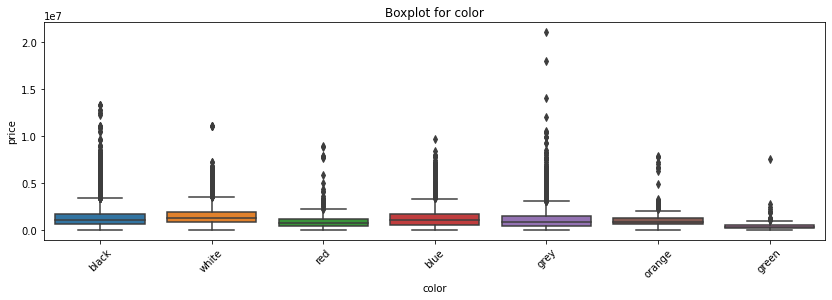

Найдены статистически значимые различия для колонки color


In [327]:
df_train = df[df.price != 0]
get_boxplot('color')
get_stat_dif('color')

### Работа с полем fuel_type

In [328]:
df['fuel_type'].value_counts(dropna=False)

бензин     12008
дизель      6185
гибрид        30
электро        4
Name: fuel_type, dtype: int64

Это также категориальный (номинативный) признак. Ситуация со значениями поля тоже выглядит хорошо, пропусков нет, формат значений единый. Построим распределение значений и проверим признак на статистическую значимость.

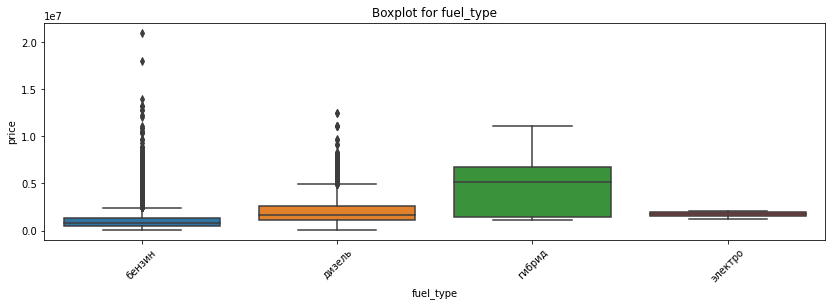

Найдены статистически значимые различия для колонки fuel_type


In [329]:
get_boxplot('fuel_type')
get_stat_dif('fuel_type')

### Работа с полем model_date

In [330]:
df['model_date'].unique()

array([2007., 2017., 2011., 2015., 2004., 2014., 2018., 1965., 2005.,
       2008., 2001., 1998., 1990., 1975., 1982., 1937., 1936., 1949.,
       2013., 2009., 2000., 2016., 1995., 2002., 1987., 1981., 1972.,
       2003., 1957., 2012., 1994., 2019., 1986., 1977., 1989., 1999.,
       1992., 1988., 2010., 2006., 1976.])

Это либо числовой, либо категориальный (порядковый) признак (в дальнейшем мы проведем анализ данного признака и в рамках числового, и категориального). Приведем его к целочисленному типу данных и посмотрим на распеделение значений.

In [331]:
df['model_date'] = df['model_date'].apply(lambda x: int(x))
df['model_date'].unique()

array([2007, 2017, 2011, 2015, 2004, 2014, 2018, 1965, 2005, 2008, 2001,
       1998, 1990, 1975, 1982, 1937, 1936, 1949, 2013, 2009, 2000, 2016,
       1995, 2002, 1987, 1981, 1972, 2003, 1957, 2012, 1994, 2019, 1986,
       1977, 1989, 1999, 1992, 1988, 2010, 2006, 1976], dtype=int64)

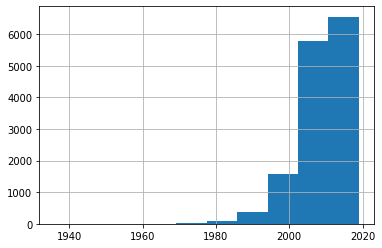

In [332]:
df_train = df[df.price != 0]
df_train['model_date'].hist()

Из графика видно, что в основном дата производства модели не более 20-25 лет назад. Посмотрим, есть ли выбросы.

25-й перцентиль: 2006.0, 75-й перцентиль: 2013.0, IQR: 7.0,  Границы выбросов: [1995.5, 2023.5].


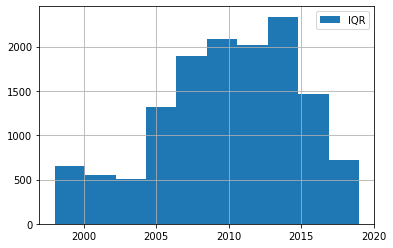

In [333]:
check_for_outliers('model_date', 10)

In [334]:
df['model_date'].value_counts(dropna=False, bins=5)

(2002.4, 2019.0]      15879
(1985.8, 2002.4]       2232
(1969.2, 1985.8]        103
(1935.916, 1952.6]       10
(1952.6, 1969.2]          3
Name: model_date, dtype: int64

По формуле получилось слишком много выбросов (все модели, выпущенные более 25 лет назад), но так как год выпуска - это важная составляющая (старые модели могут иметь меньшую стоимость, раритетно старые - наоборот, большую), то оставим все значения как есть.

### Работа с полями name и engine_displacement

In [335]:
df['name'].unique()

array(['116i 1.6 AT (115 л.с.)', '118i 1.5 AT (136 л.с.)',
       '116i 1.6 AT (136 л.с.)', '118i 2.0 AT (136 л.с.)',
       '118i 2.0 AT (129 л.с.)', '118i 1.6 AT (170 л.с.)',
       '120i 2.0 AT (150 л.с.)', '120d 2.0d AT (177 л.с.)',
       '118i 1.6 AT (136 л.с.)', '118d 2.0d MT (122 л.с.)',
       'M135i xDrive 3.0 AT (320 л.с.) 4WD', '118i 1.6 MT (170 л.с.)',
       '135i 3.0 AMT (306 л.с.)', '120d 2.0d AT (184 л.с.)',
       '125i 3.0 AT (218 л.с.)', 'M140i 3.0 AT (340 л.с.)',
       '120d 2.0d MT (184 л.с.) 4WD', '116i 1.6 MT (122 л.с.)',
       '116i 1.6 MT (115 л.с.)', '120i 2.0 MT (156 л.с.)',
       '130i 3.0 MT (265 л.с.)', '120d 2.0d MT (177 л.с.)',
       '120i 2.0 AT (156 л.с.)', '130i 3.0 AT (265 л.с.)',
       '120i 2.0 AT (184 л.с.)', '116i 1.6 MT (136 л.с.)',
       '116i 1.6 AT (122 л.с.)', '135i 3.0 AT (306 л.с.)',
       '118i 2.0 MT (143 л.с.)', '118d 2.0d AT (143 л.с.)',
       '2.0d AT (190 л.с.) 4WD', '1.5 AT (136 л.с.)',
       '3.0 AT (340 л.с.) 4WD', '220i

In [336]:
df['engine_displacement'].value_counts(dropna=False)

2.0 LTR    1538
3.0 LTR    1353
30d        1157
320i        945
35i         713
           ... 
2.8           1
3.4 LTR       1
316d          1
733i          1
315           1
Name: engine_displacement, Length: 195, dtype: int64

Признак name объединяет в себе несколько других признаков (тип управления, мощность мотора, литраж), извлечем из него информацию о вместимости (литраже) мотора, которую запишем в признак engine_displacement, содержащий множество непонятных значений.

In [337]:
import re

LIT_RE = re.compile(r'\d+[.,]\d+', re.I)

def get_litres(value):
    result = LIT_RE.findall(value)
    if len(result) == 0:
        return None
    else:
        return float(result[0])
    
df['engine_displacement'] = df['name'].apply(get_litres)
df['engine_displacement'].unique()

array([1.6, 1.5, 2. , 3. , 2.5, 1.8, 2.2, 1.9, 2.8, 1.7, 2.9, 4.4, 4.8,
       3.4, 4. , 3.5, 2.4, 2.7, 0.6, 5.4, 6.6, 6. , 3.6, 5. , 3.2, 0.7,
       nan, 3.3, 3.8, 4.9, 4.6])

In [338]:
df[df['engine_displacement'] != df['engine_displacement']]['engine_displacement'].value_counts(dropna=False)

NaN    4
Name: engine_displacement, dtype: int64

Заполним пропуски в engine_displacement медианой, а после домножим значения на 1000 (переведем в мл) и приведем к целочисленному типу.

In [339]:
litr_median = df['engine_displacement'].median()
df['engine_displacement'] = df['engine_displacement'].apply(lambda x: x if x == x else litr_median)
df['engine_displacement'] = df['engine_displacement'].apply(lambda x: int(1000 * x))
df['engine_displacement'].value_counts(dropna=False)

2000    6763
3000    6486
4400    1430
2500    1330
1600     855
1500     303
4800     279
2200     170
1800     117
2800     114
1900      78
4000      64
3500      40
6000      27
5000      26
6600      24
2900      23
3400      20
5400      19
3600      18
4600      12
3300       8
4900       6
2700       4
700        3
600        2
3800       2
2400       2
1700       1
3200       1
Name: engine_displacement, dtype: int64

Посмотрим на распределение значений. На данный момент непонятно, числовой это признак или категориальный, но скорее всего, категориальный.

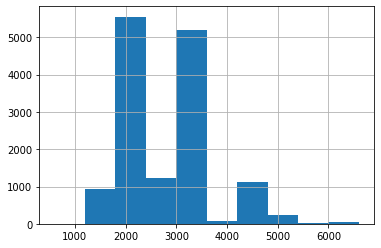

In [340]:
df_train = df[df.price != 0]
df_train['engine_displacement'].hist()

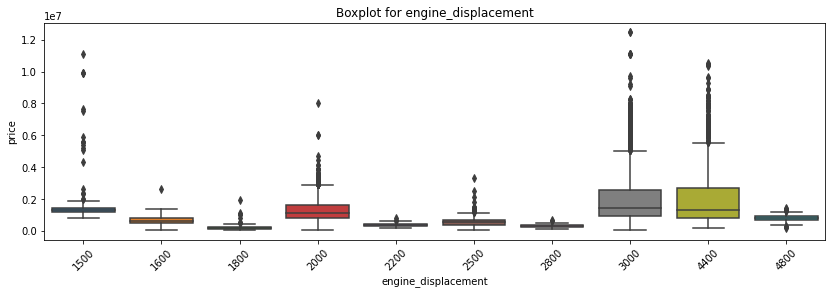

Найдены статистически значимые различия для колонки engine_displacement


In [341]:
get_boxplot('engine_displacement')
get_stat_dif('engine_displacement')

Теперь мы можем удалить ненужный признак name, так как мы извлекли из него всю нужную информацию (остальная есть в отдельных полях).

In [342]:
df.drop(columns=['name'], axis=1, inplace=True)

### Работа с полем doors_number

In [343]:
df['doors_number'].unique()

array([5., 3., 2., 4.])

Ситуация со значениями выглядит хорошо (нет пропусков, формат единый), приведем их к целочисленному типу и посмотрим на распределение значений. Это - категориальный (ординарный) признак.

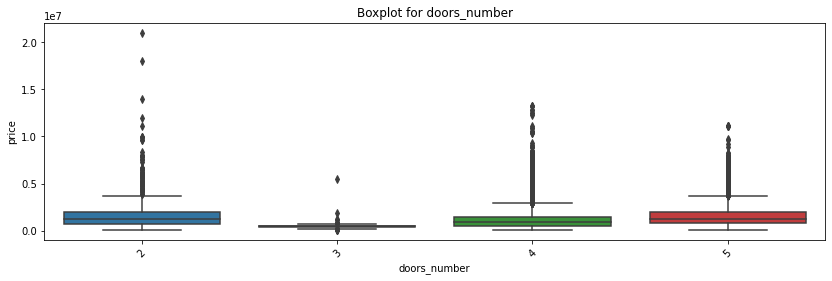

Найдены статистически значимые различия для колонки doors_number


In [344]:
df['doors_number'] = df['doors_number'].apply(lambda x: int(x))
df_train = df[df.price != 0]
get_boxplot('doors_number')
get_stat_dif('doors_number')

### Работа с полем production_date

Это так же, как и год выпуска модели, либо числовой, либо категориальный (порядковый) признак. Приведем его к целочисленному типу данных и посмотрим на распеделение значений.

In [345]:
df['production_date'].unique()

array([2008., 2011., 2017., 2014., 2013., 2009., 2012., 2006., 2005.,
       2018., 2019., 2010., 2015., 2016., 2007., 2004., 1968., 2003.,
       2002., 2001., 2000., 2020., 1999., 1998., 1996., 1992., 1979.,
       1985., 1991., 1988., 1993., 1994., 1997., 1984., 1986., 1982.,
       1995., 1981., 1990., 1989., 1983., 1987., 1937., 1949., 1947.,
       1948., 1950., 1975., 1958., 1980., 1977.])

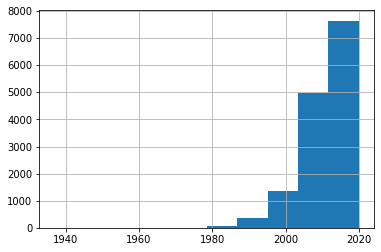

In [346]:
df['production_date'] = df['production_date'].apply(lambda x: int(x))
df_train = df[df.price != 0]
df_train['production_date'].hist()

Распределение значений очень похоже на то, которое наблюдалось у признака model_date.

25-й перцентиль: 2008.0, 75-й перцентиль: 2015.0, IQR: 7.0,  Границы выбросов: [1997.5, 2025.5].


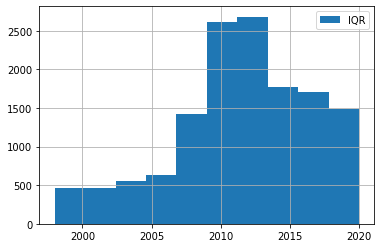

In [347]:
check_for_outliers('production_date', 10)

Границы выбросов получились тоже похожими на границы у model_date, но оставим данные как есть, так как год производства машины вероятно будет сильно влиять на цену, из соображений логики. Также есть подозрение, что корреляция между этими двумя признаками будет очень сильной (проверим это предположение чуть позже).

### Работа с полем vehicle_cofiguration

In [348]:
df['vehicle_configuration'].value_counts(dropna=False)

AUTOMATIC           13458
автоматическая       3677
MECHANICAL            791
ROBOT                 141
механическая          111
роботизированная       49
Name: vehicle_configuration, dtype: int64

Это категориальный (номинативный) признак. По факту у нас есть всего 4 значения - вариатор (в расширенной версии датасета), автоматическая, роботизированная или механическая коробка передач. Уберем дубликаты.

In [349]:
configurations = {
    'AUTOMATIC': 'автоматическая',
    'MECHANICAL': 'механическая',
    'VARIATOR': 'вариатор',
    'ROBOT': 'роботизированная'
}


def clean_vehicle_configuration(value):
    if value in configurations.keys():
        return configurations[value]
    else:
        return value


df['vehicle_configuration'] = df['vehicle_configuration'].apply(
    clean_vehicle_configuration)
df['vehicle_configuration'].value_counts(dropna=False)

автоматическая      17135
механическая          902
роботизированная      190
Name: vehicle_configuration, dtype: int64

Посмотрим на распределение значений, а также на важность признака.

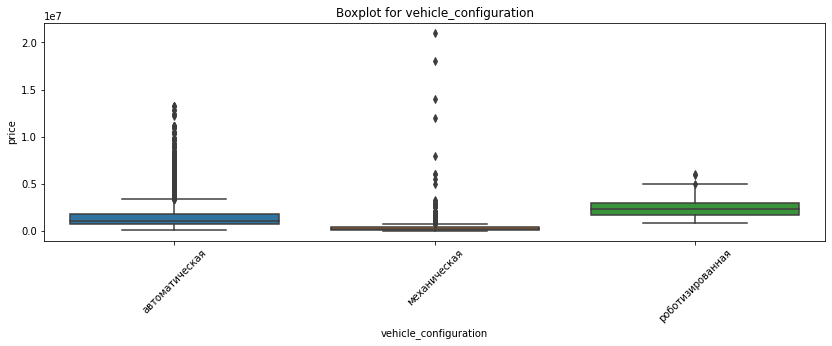

Найдены статистически значимые различия для колонки vehicle_configuration


In [350]:
df_train = df[df.price != 0]
get_boxplot('vehicle_configuration')
get_stat_dif('vehicle_configuration')

### Работа с полем engine_power

In [351]:
df['engine_power'].unique()

array([115.0, 136.0, 129.0, 170.0, 150.0, 177.0, 122.0, 320.0, 306.0,
       184.0, 218.0, 340.0, 156.0, 265.0, 143.0, 190.0, 326.0, 140.0,
       116.0, 245.0, 249.0, 387.0, 258.0, 105.0, 233.0, 192.0, 118.0,
       102.0, 163.0, 90.0, 125.0, 231.0, 113.0, 272.0, 100.0, 171.0,
       193.0, 286.0, 75.0, 234.0, 46.0, 51.0, 400.0, 204.0, 381.0, 407.0,
       252.0, 367.0, 197.0, 313.0, 300.0, 235.0, 462.0, 211.0, 333.0,
       230.0, 188.0, 450.0, 19.0, 610.0, 609.0, 445.0, 530.0, 544.0,
       410.0, 370.0, 420.0, 343.0, 431.0, 460.0, 507.0, 625.0, 560.0,
       600.0, 575.0, 360.0, 264.0, 355.0, 329.0, 269.0, 347.0, 555.0,
       449.0, 238.0, 243.0, 585.0, '190 N12', '150 N12', '407 N12',
       '249 N12', '381 N12', '245 N12', '177 N12', '184 N12', '115 N12',
       '231 N12', '156 N12', '306 N12', '218 N12', '136 N12', '235 N12',
       '286 N12', '122 N12', '265 N12', '258 N12', '340 N12', '355 N12',
       '170 N12', '333 N12', '192 N12', '610 N12', '264 N12', '555 N12',
       '

Так как мощность мотора может иметь большое множество значений, скорее всего можно считать данный признак числовым (но возможно, он является категориальным). Приведем данные к единому формату, а затем посмотрим на распределение данных.

In [352]:
def clean_engine_power(value):
    value = str(value)
    value = value.replace(' N12', '')
    return (int(float(value)))


df['engine_power'] = df['engine_power'].apply(clean_engine_power)
df['engine_power'].unique()

array([115, 136, 129, 170, 150, 177, 122, 320, 306, 184, 218, 340, 156,
       265, 143, 190, 326, 140, 116, 245, 249, 387, 258, 105, 233, 192,
       118, 102, 163,  90, 125, 231, 113, 272, 100, 171, 193, 286,  75,
       234,  46,  51, 400, 204, 381, 407, 252, 367, 197, 313, 300, 235,
       462, 211, 333, 230, 188, 450,  19, 610, 609, 445, 530, 544, 410,
       370, 420, 343, 431, 460, 507, 625, 560, 600, 575, 360, 264, 355,
       329, 269, 347, 555, 449, 238, 243, 585, 374], dtype=int64)

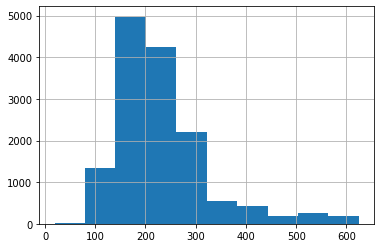

In [353]:
df_train = df[df.price != 0]
df_train['engine_power'].hist()

Распределение данных напоминает нормальное. Проверим данные на выбросы.

25-й перцентиль: 184.0, 75-й перцентиль: 272.0, IQR: 88.0,  Границы выбросов: [52.0, 404.0].


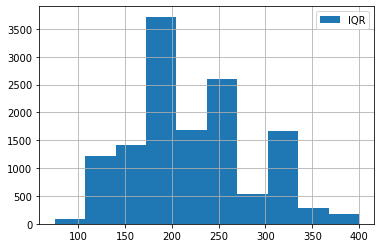

In [354]:
check_for_outliers('engine_power', 10)

Формула предлагает нам выкинуть данные о мощных моторах, но этого делать мы не будем, так как мощность мотора, по первичным предположениям, может влиять на цену.

### Работа с полем mileage

In [355]:
df['mileage'].value_counts().sort_values(ascending=False)

200000.0    179
140000.0    177
300000.0    164
160000.0    152
130000.0    146
           ... 
63242.0       1
421325.0      1
27356.0       1
23143.0       1
190800.0      1
Name: mileage, Length: 4843, dtype: int64

Это числовой признак. Посмотрим на его распределение.

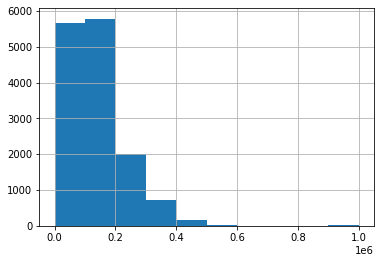

In [356]:
df_train = df[df.price != 0]
df_train['mileage'].hist()

25-й перцентиль: 70045.25, 75-й перцентиль: 185000.0, IQR: 114954.75,  Границы выбросов: [-102386.875, 357432.125].


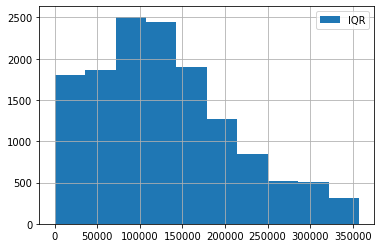

In [357]:
check_for_outliers('mileage', 10)

Приведем признак к целочисленному виду.

In [358]:
df['mileage'] = df['mileage'].apply(lambda x: int(x))

### Работа с полем drive_type

In [359]:
df['drive_type'].value_counts(dropna=False)

полный      10880
задний       7279
передний       68
Name: drive_type, dtype: int64

Признак категориальный (номинативный). Пропусков нет, и значения уже приведены к единому формату.

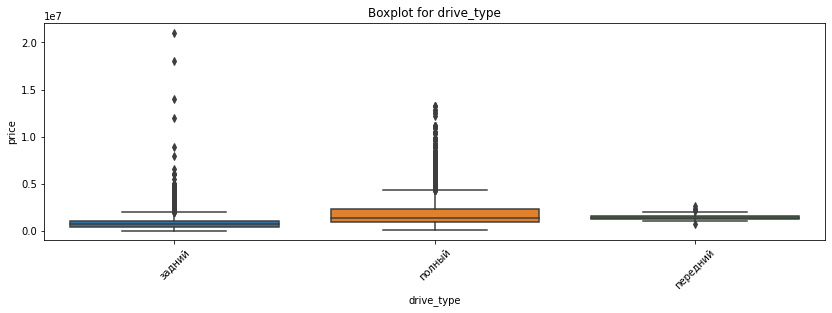

Найдены статистически значимые различия для колонки drive_type


In [360]:
df_train = df[df.price != 0]
get_boxplot('drive_type')
get_stat_dif('drive_type')

### Работа с полем steering_wheel

In [361]:
df['steering_wheel'].value_counts(dropna=False)

LEFT     14386
Левый     3837
RIGHT        4
Name: steering_wheel, dtype: int64

Это бинарный признак. Приведем значения к единому формату - 1 ("Левый") и 0 ("Правый").

In [362]:
def clean_steering_wheel(value):
    if value == 'LEFT' or value == 'Левый':
        return 1
    if value == 'RIGHT':
        return 0
    return value


df['steering_wheel'] = df['steering_wheel'].apply(clean_steering_wheel)
df.head(3)

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,steering_wheel,owners,technical_passport,customs,price
0,хэтчбек,black,бензин,2007,5,2008,автоматическая,1600,115,115000,{'id': '0'},задний,1,2,ORIGINAL,True,436000
1,хэтчбек,black,бензин,2007,5,2011,автоматическая,1600,115,39728,"{'id': '2430196', 'name': '116', 'available_op...",задний,1,1,ORIGINAL,True,595000
2,хэтчбек,white,бензин,2017,5,2017,автоматическая,1500,136,41000,{'id': '0'},задний,1,2,ORIGINAL,True,1150000


Посмотрим на распределение значений, а также на значимость данного признака.

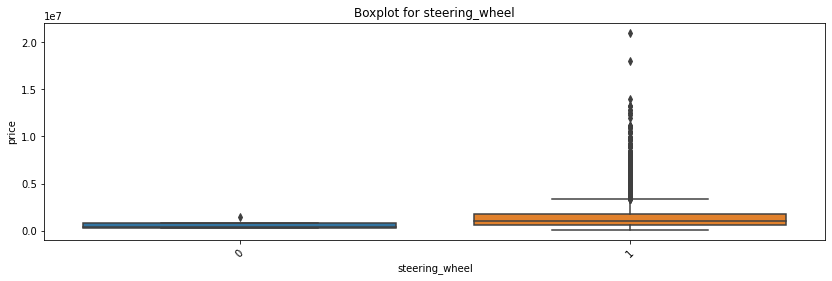

Статистически значимых различий для колонки steering_wheel не найдено


In [363]:
df_train = df[df.price != 0]
get_boxplot('steering_wheel')
get_stat_dif('steering_wheel')

Так как статистически значимых различий для данного признака не найдено (наблюдается почти стопроцентный перекос данных в сторону леворульных машин), можем его удалить из нашего датасета.

In [364]:
df = df.drop(columns=['steering_wheel'], axis=1)

### Работа с полем owners

In [365]:
df['owners'].value_counts(dropna=False)

3.0            6323
1.0            4075
2.0            3990
3 или более    1516
1 владелец     1309
2 владельца    1012
NaN               2
Name: owners, dtype: int64

Это категориальный (порядковый) признак. Также приведем все значения к единому формату.

In [366]:
def clean_owners(value):
    if value != value or pd.isnull(value):
        return value
    else:
        return int(str(value)[0])


df['owners'] = df['owners'].apply(clean_owners)
df['owners'].value_counts(dropna=False)

3.0    7839
1.0    5384
2.0    5002
NaN       2
Name: owners, dtype: int64

Заполним пропуски медианным значением.

In [367]:
owners_median = int(df['owners'].median())
df['owners'] = df['owners'].apply(
    lambda x: int(x) if x == x else owners_median)

Теперь посмотрим на распределение данных и значимость признака.

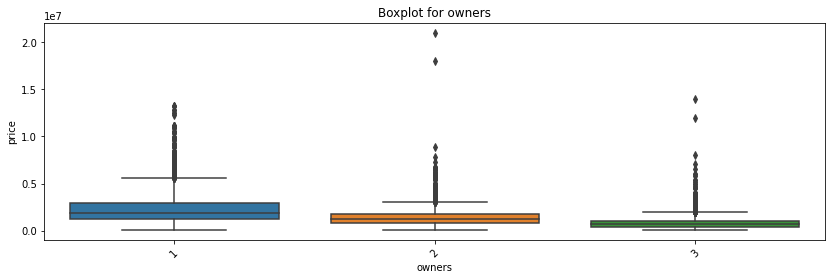

Найдены статистически значимые различия для колонки owners


In [368]:
df_train = df[df.price != 0]
get_boxplot('owners')
get_stat_dif('owners')

### Работа с полем technical_passport

In [369]:
df['technical_passport'].value_counts(dropna=False)

ORIGINAL     12521
Оригинал      3463
DUPLICATE     1869
Дубликат       374
Name: technical_passport, dtype: int64

Это бинарный признак. Также приведем значения к единому формату, а затем заполним пропуски модой.

In [370]:
def clean_technical_passport(value):
    if value == 'ORIGINAL' or value == 'Оригинал':
        return 1
    if value == 'DUPLICATE' or value == 'Дубликат':
        return 0
    return value


df['technical_passport'] = df['technical_passport'].apply(
    clean_technical_passport)
passport_mode = df['technical_passport'].mode()[0]
df['technical_passport'] = df['technical_passport'].apply(
    lambda x: x if x == x else passport_mode)
df['technical_passport'].value_counts(dropna=False)

1    15984
0     2243
Name: technical_passport, dtype: int64

Теперь также посмотрим, как распределены значения, и на важность признака.

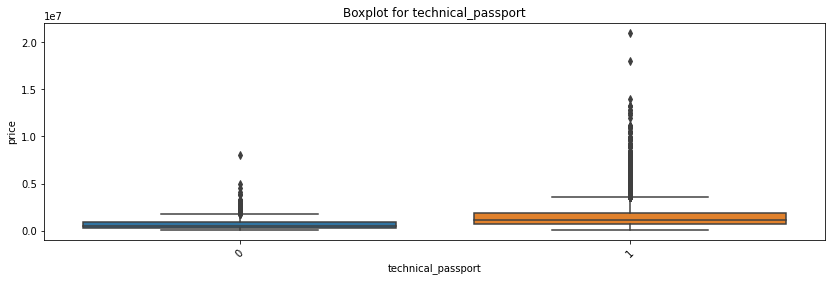

Найдены статистически значимые различия для колонки technical_passport


In [371]:
df_train = df[df.price != 0]
get_boxplot('technical_passport')
get_stat_dif('technical_passport')

### Работа с полем customs

In [372]:
df['customs'].value_counts(dropna=False)

True          14390
Растаможен     3837
Name: customs, dtype: int64

Если привести значения к одному формату, в данном признаке у нас всего одно значение - "Растаможен", а значит, данный признак бесполезен, и его можно удалить.

In [373]:
df.drop(columns=['customs'], axis=1, inplace=True)
df.head(3)

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,owners,technical_passport,price
0,хэтчбек,black,бензин,2007,5,2008,автоматическая,1600,115,115000,{'id': '0'},задний,2,1,436000
1,хэтчбек,black,бензин,2007,5,2011,автоматическая,1600,115,39728,"{'id': '2430196', 'name': '116', 'available_op...",задний,1,1,595000
2,хэтчбек,white,бензин,2017,5,2017,автоматическая,1500,136,41000,{'id': '0'},задний,2,1,1150000


### Работа с полем complectation

In [374]:
df['complectation'].unique()

array(["{'id': '0'}",
       "{'id': '2430196', 'name': '116', 'available_options': ['airbag-passenger', 'lock', 'electro-mirrors', 'computer', 'seat-transformation', 'wheel-power', 'fabric-seats', 'airbag-side', 'abs', 'esp', 'audiopreparation', 'electro-window-back', 'airbag-driver', 'electro-window-front', 'audiosystem-cd', 'wheel-configuration2', 'wheel-configuration1', 'immo']}",
       "{'id': '7707468', 'name': '116i', 'available_options': ['sport-seats', 'multi-wheel', 'xenon', 'airbag-passenger', 'lock', 'electro-mirrors', 'mirrors-heat', 'start-stop-function', 'automatic-lighting-control', 'computer', 'seat-transformation', 'wheel-power', 'light-cleaner', 'airbag-side', 'abs', 'wheel-leather', 'esp', 'usb', 'audiopreparation', 'ashtray-and-cigarette-lighter', 'front-centre-armrest', 'electro-window-back', '16-inch-wheels', 'combo-interior', 'condition', 'park-assist-r', 'airbag-driver', 'isofix', 'electro-window-front', 'airbag-curtain', 'paint-metallic', 'start-button', 'ptf

Для тестового и тренировочного датасета слишком разный набор значений, обработаем датасеты по отдельности.

In [375]:
df_train = df[df.price != 0]
df_test = df[df.price == 0]

#### Обработка тренировочного датасета

In [376]:
def parse_train_complectation(value):
    if value != value or pd.isnull(value):
        return []
    result = value.replace(' ', '')
    result = result.replace("'", '')
    first_bracket = result.find('[')
    second_bracket = result.find(']')
    if first_bracket != -1 and second_bracket != -1:
        return result[first_bracket+1:second_bracket].split(',')
    else:
        return []


df_train['complectation'] = df_train['complectation'].apply(
    parse_train_complectation)

In [377]:
# соберем все уникальные названия в признаке комплектации
from collections import defaultdict

complectation = defaultdict(int)

for value in df_train['complectation']:
    if value == value and value != None:
        for item in value:
            complectation[item] += 1

In [378]:
len(complectation.keys())

141

У нас 141 уникальное значение для тренировочного датасета. Если генерировать по всем ним столбцы с помощью get_dummies, то получится слишком много признаков, так что оставим N наиболее часто встречающихся.

In [379]:
MOST_FREQUENT_NUM = 50
sort_complectation = sorted(complectation.items(),
                            key=lambda x: x[1], reverse=True)
most_frequent_items = []
for item in sort_complectation[:MOST_FREQUENT_NUM]:
    most_frequent_items.append(item[0])

# удалим из списка самых часто встречающихся значений те, которым не нашлось сопоставления на русском языке
# нет данных по: dha,power-latching-doors,reduce-spare-wheel,laminated-safety-glass,drl,sport-pedals,wheel-configuration2
# windcleaner-heat, door-sill-panel,heated-wash-system, music-super, servo, fabric-seats, hcc, wheel-configuration1,
not_existing_items = ['dha', 'power-latching-doors', 'reduce-spare-wheel', 'laminated-safety-glass', 'drl',
                      'sport-pedals', 'wheel-configuration2', 'windcleaner-heat', 'door-sill-panel', 'heated-wash-system',
                      'music-super', 'servo', 'fabric-seats', 'hcc', 'wheel-configuration1']
for item in not_existing_items:
    if item in most_frequent_items:
        most_frequent_items.remove(item)


def fill_complectation_train_item(value):
    if item in value:
        return 1
    else:
        return 0


for item in most_frequent_items:
    df_train[item] = df_train['complectation'].apply(
        fill_complectation_train_item)

df_train.head()

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,owners,technical_passport,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,...,rain-sensor,front-centre-armrest,light-sensor,condition,park-assist-r,start-button,seat-transformation,start-stop-function,third-rear-headrest,automatic-lighting-control,aux,light-cleaner,cruise-control,park-assist-f,ashtray-and-cigarette-lighter,12v-socket,usb,xenon,bluetooth,wheel-heat,leather,passenger-seat-electric,paint-metallic,wheel-power,electro-trunk
0,хэтчбек,black,бензин,2007,5,2008,автоматическая,1600,115,115000,[],задний,2,1,436000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,хэтчбек,black,бензин,2007,5,2011,автоматическая,1600,115,39728,"[airbag-passenger, lock, electro-mirrors, comp...",задний,1,1,595000,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,хэтчбек,white,бензин,2017,5,2017,автоматическая,1500,136,41000,[],задний,2,1,1150000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,хэтчбек,red,бензин,2011,5,2014,автоматическая,1600,136,87284,"[sport-seats, multi-wheel, xenon, airbag-passe...",задний,3,1,660000,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1,0,0,0,0,1,1,0
4,хэтчбек,white,бензин,2011,5,2013,автоматическая,1600,136,124000,"[sport-seats, multi-wheel, xenon, airbag-passe...",задний,3,1,575000,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1,0,0,0,0,1,1,0


#### Обработка тестового датасета

In [380]:
import json


def parse_test_complectation(value):
    if value != value or pd.isnull(value):
        return []
    value = value.replace("['", '')
    value = value.replace("']", '')
    values = json.loads(value)
    result = []
    for item in values:
        if 'values' in item.keys():
            result.extend(item['values'])
    return result


df_test['complectation'] = df_test['complectation'].apply(
    parse_test_complectation)
df_test.head()

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,owners,technical_passport,price
14390,седан,black,дизель,2016,4,2017,автоматическая,2000,190,158836,"[Антипробуксовочная система (ASR), Система ста...",задний,1,1,0
14391,седан,white,дизель,2018,4,2019,автоматическая,2000,150,10,"[Круиз-контроль, Мультифункциональное рулевое ...",задний,1,1,0
14392,седан,blue,бензин,2009,4,2012,автоматическая,4400,407,120000,"[Круиз-контроль, Мультифункциональное рулевое ...",полный,2,1,0
14393,внедорожник,white,дизель,2014,5,2015,автоматическая,3000,249,111466,"[Круиз-контроль, Система «старт-стоп», Электро...",полный,2,1,0
14394,внедорожник,blue,дизель,2014,5,2019,автоматическая,3000,381,11891,"[Круиз-контроль, Электрорегулировка руля, Муль...",полный,1,1,0


In [381]:
# соберем все уникальные названия в признаке комплектации
from collections import defaultdict

complectation_test = defaultdict(int)

for value in df_test['complectation']:
    if value == value and value != None:
        for item in value:
            complectation_test[item] += 1

In [382]:
len(complectation_test.keys())

169

Теперь необходимо сопоставить те признаки, которые мы отобрали в тренировочном датасете - необходимо найти их аналоги в русском датасете.

In [383]:
# Сопоставление данных на английском (df_train) и русском (df_test) языке
train_to_test_complectation = {
    'airbag-driver': 'Подушка безопасности водителя', 'electro-window-front': 'Электростеклоподъёмники передние',
    'lock': 'Центральный замок', 'immo': 'Иммобилайзер', 'abs': 'Антиблокировочная система (ABS)',
    'airbag-passenger': 'Подушка безопасности пассажира', 'electro-mirrors': 'Электроскладывание зеркал',
    'mirrors-heat': 'Электрообогрев боковых зеркал', 'audiopreparation': 'Аудиоподготовка', 'audiosystem-cd': 'Аудиосистема',
    'computer': 'Бортовой компьютер', 'electro-window-back': 'Электростеклоподъёмники задние',
    'airbag-side': 'Подушки безопасности боковые', 'esp': 'Система стабилизации (ESP)',
    'front-seats-heat': 'Подогрев передних сидений', 'seat-transformation': 'Складывающееся заднее сиденье',
    'climate-control-1': 'Климат-контроль 1-зонный', 'condition': 'Кондиционер', 'night-vision': 'Система ночного видения',
    'vsm': 'Система стабилизации рулевого управления (VSM)', 'alcantara': 'Алькантара (Материал салона)',
    'audiosystem-tv': 'Аудиосистема с TV', 'ya-auto': 'Яндекс.Авто', 'massage-seats': 'Сиденья с массажем',
    'dual-xenon': 'Ксеноновые/Биксеноновые фары', 'xenon': 'Ксеноновые/Биксеноновые фары',
    '14-inch-wheels': 'Диски 14', '220v-socket': 'Розетка 220V',
    'isofix-front': 'Крепление детского кресла (передний ряд) ISOFIX',
    'remote-engine-start': 'Дистанционный запуск двигателя', 'front-camera': 'Камера передняя',
    'e-adjustment-wheel': 'Электрорегулировка руля', 'laser-lights': 'Лазерные фары',
    'driver-seat-electric': 'Электрорегулировка сиденья водителя', 'eco-leather': 'Искусственная кожа (Материал салона)',
    '22-inch-wheels': 'Диски 22', 'sport-suspension': 'Спортивная подвеска', 'air-suspension': 'Пневмоподвеска',
    'wheel-memory': 'Рулевая колонка с памятью положения', 'projection-display': 'Проекционный дисплей',
    'android-auto': 'Android Auto', 'rear-seat-heat-vent': 'Вентиляция задних сидений',
    'wireless-charger': 'Беспроводная зарядка для смартфона', '21-inch-wheels': 'Диски 21',
    'activ-suspension': 'Активная подвеска', 'easy-trunk-opening': 'Открытие багажника без помощи рук',
    'programmed-block-heater': 'Программируемый предпусковой отопитель',
    'folding-tables-rear': 'Складной столик на спинках передних сидений',
    'folding-front-passenger-seat': 'Функция складывания спинки сиденья пассажира',
    'entertainment-system-for-rear-seat-passengers': 'Мультимедиа система для задних пассажиров',
    'driver-seat-memory': 'Память сиденья водителя', 'multizone-climate-control': 'Климат-контроль многозонный',
    'body-kit': 'Обвес кузова', 'electronic-gage-panel': 'Электронная приборная панель',
    'driver-seat-updown': 'Регулировка сиденья водителя по высоте', 'spare-wheel': 'Полноразмерное запасное колесо',
    '15-inch-wheels': 'Диски 15', 'apple-carplay': 'CarPlay', 'climate-control-2': 'Климат-контроль 2-зонный',
    'decorative-interior-lighting': 'Декоративная подсветка салона', 'auto-cruise': 'Адаптивный круиз-контроль',
    'passenger-seat-updown': 'Регулировка передних сидений по высоте',
    'roller-blind-for-rear-window': 'Солнцезащитная шторка на заднем стекле',
    'panorama-roof': 'Панорамная крыша / лобовое стекло', 'voice-recognition': 'Голосовое управление',
    '20-inch-wheels': 'Диски 20', 'lane-keeping-assist': 'Система контроля за полосой движения',
    'blind-spot': 'Система контроля слепых зон', 'bas': 'Система помощи при торможении (BAS, EBD)',
    'asr': 'Антипробуксовочная система (ASR)', 'third-row-seats': 'Третий ряд сидений',
    '19-inch-wheels': 'Диски 19', 'glonass': 'ЭРА-ГЛОНАСС', 'airbag-rear-side': 'Подушки безопасности боковые задние',
    '360-camera': 'Камера 360°', 'front-seats-heat-vent': 'Вентиляция передних сидений',
    'combo-interior': 'Комбинированный (Материал салона)', 'auto-park': 'Система автоматической парковки',
    'steel-wheels': 'Стальные диски', '16-inch-wheels': 'Диски 16', 'sport-seats': 'Спортивные передние сиденья',
    'windscreen-heat': 'Электрообогрев лобового стекла', 'collision-prevention-assist': 'Система предотвращения столкновения',
    'drowsy-driver-alert-system': 'Датчик усталости водителя', 'adaptive-light': 'Система адаптивного освещения',
    'high-beam-assist': 'Система управления дальним светом', 'tinted-glass': 'Тонированные стекла',
    'hatch': 'Люк', 'rear-seats-heat': 'Подогрев задних сидений', 
    'knee-airbag': 'Подушка безопасности для защиты коленей водителя',
    'steering-wheel-gear-shift-paddles': 'Подрулевые лепестки переключения передач',
    '18-inch-wheels': 'Диски 18', 'volume-sensor': 'Датчик проникновения в салон (датчик объема)',
    'electro-trunk': 'Электропривод крышки багажника', '17-inch-wheels': 'Диски 17',
    'seat-memory': 'Память передних сидений', 'wheel-heat': 'Обогрев рулевого колеса',
    'led-lights': 'Светодиодные фары', 'keyless-entry': 'Система доступа без ключа',
    'navigation': 'Навигационная система', 'rear-camera': 'Камера задняя',
    'roof-rails': 'Рейлинги на крыше', 'start-stop-function': 'Система «старт-стоп»',
    'start-button': 'Запуск двигателя с кнопки', 'automatic-lighting-control': 'Автоматический корректор фар',
    'tyre-pressure': 'Датчик давления в шинах', 'leather-gear-stick': 'Отделка кожей рычага КПП',
    'ashtray-and-cigarette-lighter': 'Прикуриватель и пепельница',
    'park-assist-f': 'Парктроник передний', 'paint-metallic': 'Металлик', 'auto-mirrors': 'Электропривод зеркал',
    'alarm': 'Сигнализация', 'leather': 'Кожа (Материал салона)', 'park-assist-r': 'Парктроник задний',
    'passenger-seat-electric': 'Электрорегулировка передних сидений', 'light-cleaner': 'Омыватель фар',
    'bluetooth': 'Bluetooth', 'usb': 'USB', '12v-socket': 'Розетка 12V', 'light-sensor': 'Датчик света',
    'rain-sensor': 'Датчик дождя', 'front-centre-armrest': 'Передний центральный подлокотник',
    'wheel-power': 'Усилитель руля', 'third-rear-headrest': 'Третий задний подголовник', 'aux': 'AUX',
    'cruise-control': 'Круиз-контроль', 'airbag-curtain': 'Подушки безопасности оконные (шторки)',
    'multi-wheel': 'Мультифункциональное рулевое колесо', 'wheel-leather': 'Отделка кожей рулевого колеса',
    'isofix': 'Крепление детского кресла (задний ряд) ISOFIX', 'ptf': 'Противотуманные фары',
    'body-mouldings': 'Декоративные молдинги', 'black-roof': 'Отделка потолка чёрной тканью',
    'drive-mode-sys': 'Система выбора режима движения',
    'power-child-locks-rear-doors': 'Блокировка замков задних дверей',
    'cooling-box': 'Охлаждаемый перчаточный ящик', 'electro-rear-seat': 'Электрорегулировка задних сидений'
}

In [384]:
def fill_complectation_test_item(value):
    if train_to_test_complectation[item] in value:
        return 1
    else:
        return 0


for item in most_frequent_items:
    df_test[item] = df_test['complectation'].apply(fill_complectation_test_item)

df_test.head()

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,owners,technical_passport,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,...,rain-sensor,front-centre-armrest,light-sensor,condition,park-assist-r,start-button,seat-transformation,start-stop-function,third-rear-headrest,automatic-lighting-control,aux,light-cleaner,cruise-control,park-assist-f,ashtray-and-cigarette-lighter,12v-socket,usb,xenon,bluetooth,wheel-heat,leather,passenger-seat-electric,paint-metallic,wheel-power,electro-trunk
14390,седан,black,дизель,2016,4,2017,автоматическая,2000,190,158836,"[Антипробуксовочная система (ASR), Система ста...",задний,1,1,0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,0,1,1,0,1,1,1,0,1,1,0,1,0,1,1,1,1,0,1,0
14391,седан,white,дизель,2018,4,2019,автоматическая,2000,150,10,"[Круиз-контроль, Мультифункциональное рулевое ...",задний,1,1,0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0,1,0,1,1,1,1,0,1,0,1,1,1,0,1,1,0,0,1,0,1
14392,седан,blue,бензин,2009,4,2012,автоматическая,4400,407,120000,"[Круиз-контроль, Мультифункциональное рулевое ...",полный,2,1,0,1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,1,1,0,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1
14393,внедорожник,white,дизель,2014,5,2015,автоматическая,3000,249,111466,"[Круиз-контроль, Система «старт-стоп», Электро...",полный,2,1,0,1,1,1,1,1,1,1,1,1,0,...,1,1,1,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,0,0,0,1
14394,внедорожник,blue,дизель,2014,5,2019,автоматическая,3000,381,11891,"[Круиз-контроль, Электрорегулировка руля, Муль...",полный,1,1,0,0,1,0,1,1,0,1,1,1,1,...,1,1,1,0,1,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1


Теперь мы извлекли дополнительную информацию по наиболее часто встречающимся значениям из комплектации, сформировали новые признаки и привели оба датасета к единому набору признаков. Снова объединим их для удобства обработки данных.

In [385]:
df = pd.concat([df_train, df_test], ignore_index=True)

for col in most_frequent_items:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки airbag-passenger
Найдены статистически значимые различия для колонки abs
Найдены статистически значимые различия для колонки airbag-driver
Найдены статистически значимые различия для колонки lock
Найдены статистически значимые различия для колонки computer
Найдены статистически значимые различия для колонки airbag-side
Найдены статистически значимые различия для колонки esp
Найдены статистически значимые различия для колонки electro-window-front
Найдены статистически значимые различия для колонки immo
Найдены статистически значимые различия для колонки electro-mirrors
Найдены статистически значимые различия для колонки mirrors-heat
Найдены статистически значимые различия для колонки electro-window-back
Найдены статистически значимые различия для колонки ptf
Найдены статистически значимые различия для колонки audiosystem-cd
Найдены статистически значимые различия для колонки audiopreparation
Найдены статистически значимые различия для 

Не найдено статистически значимых различий для признаков xenon и volume-sensor, поэтому можно их сразу удалить из датасета.

In [386]:
if 'xenon' in df.columns:
    df = df.drop(columns=['xenon'], axis=1)
if 'volume-sensor' in df.columns:
    df = df.drop(columns=['volume-sensor'], axis=1)

df_train = df[df.price != 0]
df_test = df[df.price == 0]

## Корреляция признаков

### Корреляция числовых признаков

In [387]:
df.head()

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,owners,technical_passport,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,...,front-seats-heat,rain-sensor,front-centre-armrest,light-sensor,condition,park-assist-r,start-button,seat-transformation,start-stop-function,third-rear-headrest,automatic-lighting-control,aux,light-cleaner,cruise-control,park-assist-f,ashtray-and-cigarette-lighter,12v-socket,usb,bluetooth,wheel-heat,leather,passenger-seat-electric,paint-metallic,wheel-power,electro-trunk
0,хэтчбек,black,бензин,2007,5,2008,автоматическая,1600,115,115000,[],задний,2,1,436000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,хэтчбек,black,бензин,2007,5,2011,автоматическая,1600,115,39728,"[airbag-passenger, lock, electro-mirrors, comp...",задний,1,1,595000,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,хэтчбек,white,бензин,2017,5,2017,автоматическая,1500,136,41000,[],задний,2,1,1150000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,хэтчбек,red,бензин,2011,5,2014,автоматическая,1600,136,87284,"[sport-seats, multi-wheel, xenon, airbag-passe...",задний,3,1,660000,1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,1,1,1,1,1,1,1,0,1,0,0,1,1,1,0,0,0,0,1,1,0
4,хэтчбек,white,бензин,2011,5,2013,автоматическая,1600,136,124000,"[sport-seats, multi-wheel, xenon, airbag-passe...",задний,3,1,575000,1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,1,1,1,1,1,1,1,0,1,0,0,1,1,1,0,0,0,0,1,1,0


Для начала посмотрим на корреляцию числовых переменных. Для этого построим heatmap по (предположительно) числовым признакам. Так как нет полной уверенности, что model_date, production_date, engine_displacement и engine_power это числовые (а не ординарные) признаки, проанализируем их и в числовых, и в категориальных.

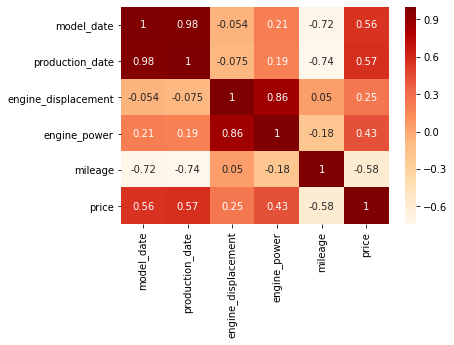

In [388]:
def heatmap(x,y,dataframe):
    sns.heatmap(dataframe.corr(),cmap="OrRd",annot=True)
    plt.show()
    
dimension_col_list = ['model_date','production_date','engine_displacement','engine_power','mileage','price']

heatmap(10,10,df_train.filter(dimension_col_list))

Видна сильная корреляция данных между model_date и production_date. Также наблюдается сильная корреляция между engine_displacement и engine_power. Проанализируем эти признаки еще и в категориальных, а пока что удалим признак complectation, так как мы уже достали из него всю необходимую информацию.

In [389]:
df.drop(columns=['complectation'], axis=1, inplace=True)
df_train = df[df.price != 0]
df_test = df[df.price == 0]

Посмотрим на важность оставшихся признаков.

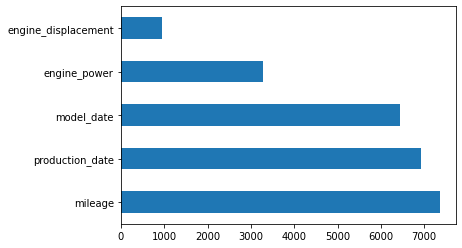

In [390]:
from sklearn.feature_selection import f_regression
from pandas import Series

num_columns = ['model_date', 'production_date',
               'engine_displacement', 'engine_power', 'mileage']
f_test, _ = f_regression(
    df_train[num_columns].values, df_train['price'].values)
imp_num = Series(f_test, index=num_columns)
imp_num.sort_values(ascending=False, inplace=True)
imp_num.plot(kind='barh')

### Корреляция бинарных признаков

Так как тест Стьюдента показал значимость практически на всех нечисловых признаках, попробуем посмотреть значимость признаков по другой метрике. Будем использовать mutual_info_regression из библиотеки sklearn.

In [391]:
import numpy as np

# сформируем список бинарных колонок
def get_binary_columns(datafame):
    binary_cols = []
    for column in datafame.columns:
        vals = datafame[column].unique()
        if len(vals) == 2 and 1 in vals and 0 in vals:
            binary_cols.append(column)
    return binary_cols


binary_columns = get_binary_columns(df_train)
print(binary_columns)

['technical_passport', 'airbag-passenger', 'abs', 'airbag-driver', 'lock', 'computer', 'airbag-side', 'esp', 'electro-window-front', 'immo', 'electro-mirrors', 'mirrors-heat', 'electro-window-back', 'ptf', 'audiosystem-cd', 'audiopreparation', 'airbag-curtain', 'wheel-leather', 'isofix', 'multi-wheel', 'climate-control-1', 'front-seats-heat', 'rain-sensor', 'front-centre-armrest', 'light-sensor', 'condition', 'park-assist-r', 'start-button', 'seat-transformation', 'start-stop-function', 'third-rear-headrest', 'automatic-lighting-control', 'aux', 'light-cleaner', 'cruise-control', 'park-assist-f', 'ashtray-and-cigarette-lighter', '12v-socket', 'usb', 'bluetooth', 'wheel-heat', 'leather', 'passenger-seat-electric', 'paint-metallic', 'wheel-power', 'electro-trunk']


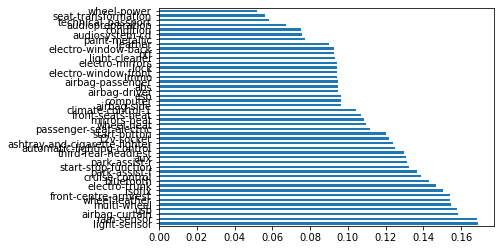

In [392]:
from pandas import Series
from sklearn.feature_selection import mutual_info_regression

imp_bin = Series(mutual_info_regression(
    X=df_train[binary_columns].values, y=df_train['price'].values, discrete_features=True), index=binary_columns)
imp_bin.sort_values(ascending=False, inplace=True)
imp_bin.plot(kind='barh')

Отберем бинарные признаки с важностью выше некоторого порога. Затем попробуем применить к ним корреляцию Мэтьюса для бинарных признаков.

In [393]:
IMPORTANCE = 0.05

print(imp_bin[imp_bin >= IMPORTANCE])

columns_to_delete = list(imp_bin[imp_bin < IMPORTANCE].index)

#df.drop(columns=columns_to_delete, axis=1, inplace=True)
df_train = df[df.price != 0]
df_test = df[df.price == 0]

light-sensor                     0.168750
rain-sensor                      0.168141
airbag-curtain                   0.158054
usb                              0.157508
multi-wheel                      0.154401
wheel-leather                    0.154215
front-centre-armrest             0.153820
isofix                           0.150389
electro-trunk                    0.146765
bluetooth                        0.143060
cruise-control                   0.138852
park-assist-f                    0.136785
start-stop-function              0.132177
park-assist-r                    0.131028
aux                              0.130955
third-rear-headrest              0.129872
automatic-lighting-control       0.124738
ashtray-and-cigarette-lighter    0.123688
12v-socket                       0.121740
start-button                     0.120329
passenger-seat-electric          0.111661
wheel-heat                       0.109341
mirrors-heat                     0.108461
front-seats-heat                 0

Отберем по корреляции Мэтьюса те бинарные признаки, корреляция которых менее заданного порога.

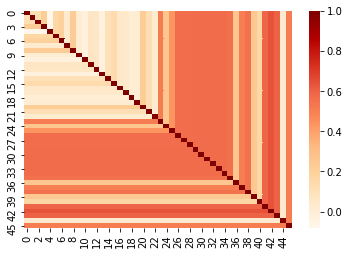

In [394]:
from sklearn.metrics import matthews_corrcoef

binary_columns = list(imp_bin[imp_bin >= IMPORTANCE].index)

# получение матрицы корреляции Мэттьюса
def get_mattiews_correlation(dataframe, columns):
    mattiews_corr = np.zeros((len(columns), len(columns)))
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            if j >= i:  # получаем только для половины матрицы, так как она симметрична
                coef = matthews_corrcoef(df_train[col1], df_train[col2])
            mattiews_corr[i, j] = coef
            mattiews_corr[j, i] = coef
    return mattiews_corr


mattiews_corr = get_mattiews_correlation(df_train, binary_columns)
print()

sns.heatmap(mattiews_corr, cmap="OrRd")
plt.show()

In [395]:
binary_to_delete = []
binary_to_implement = []

CORR_VALUE = 0.6

for i, col1 in enumerate(binary_columns):
    if col1 not in binary_to_delete and col1 not in binary_to_implement:
        binary_to_implement.append(col1)
    for j, col2 in enumerate(binary_columns):
        if abs(mattiews_corr[i, j]) >= CORR_VALUE and abs(mattiews_corr[i, j]) != 1:
            if col2 not in binary_to_delete and col2 not in binary_to_implement:
                binary_to_delete.append(col2)

print('Всего отобранных по важности бинарных признаков: {}'.format(len(binary_columns)))
print('Количество бинарных признаков, которые можно оставить: {}'.format(
    len(binary_to_implement)))
print('Количество бинарных признаков, которые нужно убрать: {}'.format(
    len(binary_to_delete)))

Всего отобранных по важности бинарных признаков: 46
Количество бинарных признаков, которые можно оставить: 44
Количество бинарных признаков, которые нужно убрать: 2


In [396]:
df.drop(columns=binary_to_delete, axis=1, inplace=True)
df_train = df[df.price != 0]
df_test = df[df.price == 0]

df.head(3)

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,drive_type,owners,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,mirrors-heat,electro-window-back,...,front-seats-heat,rain-sensor,front-centre-armrest,light-sensor,condition,park-assist-r,start-button,seat-transformation,start-stop-function,third-rear-headrest,automatic-lighting-control,aux,light-cleaner,cruise-control,park-assist-f,ashtray-and-cigarette-lighter,12v-socket,usb,bluetooth,wheel-heat,leather,passenger-seat-electric,paint-metallic,wheel-power,electro-trunk
0,хэтчбек,black,бензин,2007,5,2008,автоматическая,1600,115,115000,задний,2,436000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,хэтчбек,black,бензин,2007,5,2011,автоматическая,1600,115,39728,задний,1,595000,1,1,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,хэтчбек,white,бензин,2017,5,2017,автоматическая,1500,136,41000,задний,2,1150000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [397]:
binary_to_delete

['audiopreparation', 'technical_passport']

### Корреляция категориальных (ординарных) признаков

In [398]:
# определим колонки, которые надо переводить в численный вид (уже готовый вид - doors_number и owners)
categorical_columns = ['body_type', 'color',
                       'fuel_type', 'vehicle_configuration', 'drive_type']

for column in categorical_columns:
    if column in df.columns:
        df[column] = pd.Categorical(df[column]).codes

categorical_columns.append('doors_number')
categorical_columns.append('owners')
categorical_columns.append('production_date')
categorical_columns.append('model_date')
categorical_columns.append('engine_displacement')
categorical_columns.append('engine_power')

df.head(3)

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,drive_type,owners,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,mirrors-heat,electro-window-back,...,front-seats-heat,rain-sensor,front-centre-armrest,light-sensor,condition,park-assist-r,start-button,seat-transformation,start-stop-function,third-rear-headrest,automatic-lighting-control,aux,light-cleaner,cruise-control,park-assist-f,ashtray-and-cigarette-lighter,12v-socket,usb,bluetooth,wheel-heat,leather,passenger-seat-electric,paint-metallic,wheel-power,electro-trunk
0,6,0,0,2007,5,2008,0,1600,115,115000,0,2,436000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,0,0,2007,5,2011,0,1600,115,39728,0,1,595000,1,1,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,6,7,0,2017,5,2017,0,1500,136,41000,0,2,1150000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Теперь все категориальные признаки приведены к числовому формату, применим к ним корреляцию по Кендаллу.

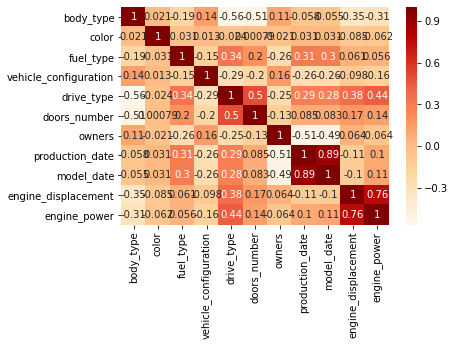

In [399]:
df_train = df[df.price != 0]
df_test = df[df.price == 0]

sns.heatmap(df_train.filter(categorical_columns).corr(
    method='kendall'), cmap="OrRd", annot=True)
plt.show()

Корреляция между всеми признаками слабая или умеренная, явной мультиколлинеарности не наблюдается, кроме как между model_date и production_date, а также между engine_power и engine_displacement, но она слабее, попробуем оставить оба этих признака. Оставим из них признаки production_date, engine_displacement и engine_power, после чего попробуем определить важность признаков с помощью mutual_info_regression.

In [400]:
#df.drop(columns=['engine_displacement', 'model_date'], axis=1, inplace=True)
df.drop(columns=['model_date'], axis=1, inplace=True)

categorical_columns = ['body_type', 'color', 'fuel_type', 'vehicle_configuration', 'drive_type',
                       'engine_power', 'owners', 'doors_number', 'production_date','engine_displacement']

df_train = df[df.price != 0]
df_test = df[df.price == 0]

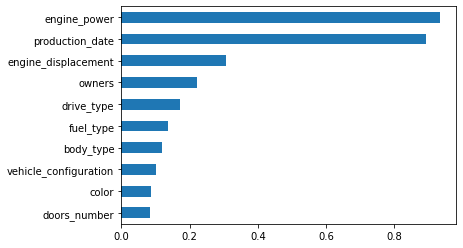

In [401]:
imp_cat = Series(mutual_info_regression(X=df_train[categorical_columns].values,
                                        y=df_train['price'].values, discrete_features=True),
                 index=categorical_columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Отберем наиболее важные признаки со значимостью выше заданного порога.

In [402]:
IMPORTANCE = 0.1
print(imp_cat[imp_cat >= IMPORTANCE])

columns_to_delete = list(imp_cat[imp_cat < IMPORTANCE].index)

df.drop(columns=columns_to_delete, axis=1, inplace=True)
df_train = df[df.price != 0]
df_test = df[df.price == 0]

df.head(3)

vehicle_configuration    0.100798
body_type                0.118727
fuel_type                0.137767
drive_type               0.170457
owners                   0.220498
engine_displacement      0.306044
production_date          0.893659
engine_power             0.934884
dtype: float64


,body_type,fuel_type,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,drive_type,owners,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,mirrors-heat,electro-window-back,ptf,audiosystem-cd,airbag-curtain,...,front-seats-heat,rain-sensor,front-centre-armrest,light-sensor,condition,park-assist-r,start-button,seat-transformation,start-stop-function,third-rear-headrest,automatic-lighting-control,aux,light-cleaner,cruise-control,park-assist-f,ashtray-and-cigarette-lighter,12v-socket,usb,bluetooth,wheel-heat,leather,passenger-seat-electric,paint-metallic,wheel-power,electro-trunk
0,6,0,2008,0,1600,115,115000,0,2,436000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,0,2011,0,1600,115,39728,0,1,595000,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,6,0,2017,0,1500,136,41000,0,2,1150000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [403]:
df['engine_displacement'].nunique()

30

In [404]:
df['engine_power'].nunique()

87

Итак, мы оставили в датасете только наиболее важные, на первый взгляд, признаки. Теперь попробуем построить модель на основе полученных данных.

## Предобработка данных перед построением моделей

Чтобы модель принимала данные корректно, необходимо выделить отдельные значения в категориальных (номинативных, закодированных числами) признаках в отдельные признаки, это можно сделать с помощью get_dummies.

In [405]:
categorical_columns = ['body_type', 'color', 'fuel_type', 'vehicle_configuration', 'drive_type',
                       'owners', 'doors_number']

for col in categorical_columns:
    if col in df.columns:
        col_dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, col_dummies], axis=1)
        df.drop(columns=[col], axis=1, inplace=True)

df.head()

,production_date,engine_displacement,engine_power,mileage,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,mirrors-heat,electro-window-back,ptf,audiosystem-cd,airbag-curtain,wheel-leather,isofix,multi-wheel,climate-control-1,front-seats-heat,...,leather,passenger-seat-electric,paint-metallic,wheel-power,electro-trunk,body_type_0,body_type_1,body_type_2,body_type_3,body_type_4,body_type_5,body_type_6,fuel_type_0,fuel_type_1,fuel_type_2,fuel_type_3,vehicle_configuration_0,vehicle_configuration_1,vehicle_configuration_2,drive_type_0,drive_type_1,drive_type_2,owners_1,owners_2,owners_3
0,2008,1600,115,115000,436000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0
1,2011,1600,115,39728,595000,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0
2,2017,1500,136,41000,1150000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0
3,2014,1600,136,87284,660000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,...,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1
4,2013,1600,136,124000,575000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,...,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1


## Построение модели

Разобьем данные на тренировочные (тренировочные и валидационные) и тестовые.

In [408]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

VAL_SIZE = 0.2
RANDOM_SEED = 42

df_train = df[df.price != 0]
df_test = df[df.price == 0]

X = df_train.drop(columns=['price'], axis=1)
y = df_train['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)
X_test_target = df_test.drop(columns=['price'], axis=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test_target = scaler.transform(X_test_target)

### Стекинг

Все параметры для используемых далее моделей подбирались отдельно, чтобы выбрать оптимальные и минимизировать время работы всего кода (подбор осуществлялся с помощью GridSearchCV). Ниже представлены отобранные модели для последующего стекинга с указанием их метрик качества, а также сам стекинг.

In [410]:
import numpy as np

# реализация метрики mape
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**Регрессионая модель Decision Tree**

In [411]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=RANDOM_SEED, criterion='mae', max_depth=15, min_samples_split=3,
                           min_samples_leaf=3)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print(mape(y_test, dt_pred))

13.479505244091886


**Регрессионая модель Random Forest**

In [412]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=RANDOM_SEED, criterion='mse', n_jobs=-1, min_samples_split=7,
                           max_depth=25, n_estimators=170)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(mape(y_test, rf_pred))

12.570739021765117


**Регрессионая модель библиотеки XGBoost**

In [413]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(random_state=RANDOM_SEED, n_estimators=250, max_depth=12, learning_rate=0.03,
                        n_jobs=-1)

xgbr.fit(X_train, y_train)
xgbr_pred = xgbr.predict(X_test)
print(mape(y_test, xgbr_pred))

12.279432353723958


**Регрессионая модель библиотеки LightGBM**

In [414]:
import lightgbm as lgb

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['mape'],
    'learning_rate': 0.002,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 25,
    'verbose': 0,
    #"max_depth": 25,
    "num_leaves": 130,  
    "max_bin": 512,
    "num_iterations": 50000,
    "n_estimators": 300,
    'random_seed': RANDOM_SEED,
    'silent':True,
    'reg_alpha':0.01
}

gbm = lgb.LGBMRegressor(**hyper_params)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='mape',
        early_stopping_rounds=1000)
lgb_pred = gbm.predict(X_test)
print(mape(y_test, lgb_pred))

[1]	valid_0's mape: 1.17191
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's mape: 1.16969
[3]	valid_0's mape: 1.16746
[4]	valid_0's mape: 1.16524
[5]	valid_0's mape: 1.16305
[6]	valid_0's mape: 1.16096
[7]	valid_0's mape: 1.15875
[8]	valid_0's mape: 1.15657
[9]	valid_0's mape: 1.15437
[10]	valid_0's mape: 1.15218
[11]	valid_0's mape: 1.14999
[12]	valid_0's mape: 1.14798
[13]	valid_0's mape: 1.1458
[14]	valid_0's mape: 1.14362
[15]	valid_0's mape: 1.14145
[16]	valid_0's mape: 1.13929
[17]	valid_0's mape: 1.13714
[18]	valid_0's mape: 1.13499
[19]	valid_0's mape: 1.13285
[20]	valid_0's mape: 1.13071
[21]	valid_0's mape: 1.12857
[22]	valid_0's mape: 1.12654
[23]	valid_0's mape: 1.12441
[24]	valid_0's mape: 1.12228
[25]	valid_0's mape: 1.12016
[26]	valid_0's mape: 1.11806
[27]	valid_0's mape: 1.11596
[28]	valid_0's mape: 1.11386
[29]	valid_0's mape: 1.11181
[30]	valid_0's mape: 1.10973
[31]	valid_0's mape: 1.10772
[32]	valid_0's mape: 1.10564
[33]	valid_0's mape

[284]	valid_0's mape: 0.699517
[285]	valid_0's mape: 0.698288
[286]	valid_0's mape: 0.697061
[287]	valid_0's mape: 0.695875
[288]	valid_0's mape: 0.694652
[289]	valid_0's mape: 0.693435
[290]	valid_0's mape: 0.692221
[291]	valid_0's mape: 0.691008
[292]	valid_0's mape: 0.689834
[293]	valid_0's mape: 0.688624
[294]	valid_0's mape: 0.687456
[295]	valid_0's mape: 0.68625
[296]	valid_0's mape: 0.685093
[297]	valid_0's mape: 0.683883
[298]	valid_0's mape: 0.682677
[299]	valid_0's mape: 0.681479
[300]	valid_0's mape: 0.680287
[301]	valid_0's mape: 0.679105
[302]	valid_0's mape: 0.677926
[303]	valid_0's mape: 0.676784
[304]	valid_0's mape: 0.675576
[305]	valid_0's mape: 0.674403
[306]	valid_0's mape: 0.673207
[307]	valid_0's mape: 0.67204
[308]	valid_0's mape: 0.670875
[309]	valid_0's mape: 0.66971
[310]	valid_0's mape: 0.668549
[311]	valid_0's mape: 0.667389
[312]	valid_0's mape: 0.666235
[313]	valid_0's mape: 0.665078
[314]	valid_0's mape: 0.663924
[315]	valid_0's mape: 0.662774
[316]	valid

[551]	valid_0's mape: 0.446476
[552]	valid_0's mape: 0.445743
[553]	valid_0's mape: 0.445023
[554]	valid_0's mape: 0.444304
[555]	valid_0's mape: 0.443587
[556]	valid_0's mape: 0.442873
[557]	valid_0's mape: 0.442158
[558]	valid_0's mape: 0.441445
[559]	valid_0's mape: 0.44077
[560]	valid_0's mape: 0.440093
[561]	valid_0's mape: 0.439388
[562]	valid_0's mape: 0.438683
[563]	valid_0's mape: 0.437977
[564]	valid_0's mape: 0.437275
[565]	valid_0's mape: 0.436573
[566]	valid_0's mape: 0.435872
[567]	valid_0's mape: 0.435174
[568]	valid_0's mape: 0.434478
[569]	valid_0's mape: 0.433783
[570]	valid_0's mape: 0.433087
[571]	valid_0's mape: 0.432396
[572]	valid_0's mape: 0.431706
[573]	valid_0's mape: 0.431047
[574]	valid_0's mape: 0.430393
[575]	valid_0's mape: 0.429709
[576]	valid_0's mape: 0.429009
[577]	valid_0's mape: 0.428325
[578]	valid_0's mape: 0.427642
[579]	valid_0's mape: 0.42696
[580]	valid_0's mape: 0.426279
[581]	valid_0's mape: 0.4256
[582]	valid_0's mape: 0.424921
[583]	valid_

[830]	valid_0's mape: 0.296995
[831]	valid_0's mape: 0.296615
[832]	valid_0's mape: 0.296227
[833]	valid_0's mape: 0.295836
[834]	valid_0's mape: 0.295441
[835]	valid_0's mape: 0.295057
[836]	valid_0's mape: 0.294655
[837]	valid_0's mape: 0.294263
[838]	valid_0's mape: 0.293876
[839]	valid_0's mape: 0.293492
[840]	valid_0's mape: 0.293109
[841]	valid_0's mape: 0.292737
[842]	valid_0's mape: 0.292372
[843]	valid_0's mape: 0.292002
[844]	valid_0's mape: 0.291615
[845]	valid_0's mape: 0.291252
[846]	valid_0's mape: 0.290868
[847]	valid_0's mape: 0.290485
[848]	valid_0's mape: 0.290103
[849]	valid_0's mape: 0.289723
[850]	valid_0's mape: 0.289343
[851]	valid_0's mape: 0.288972
[852]	valid_0's mape: 0.28862
[853]	valid_0's mape: 0.288239
[854]	valid_0's mape: 0.28787
[855]	valid_0's mape: 0.287504
[856]	valid_0's mape: 0.287138
[857]	valid_0's mape: 0.28676
[858]	valid_0's mape: 0.286419
[859]	valid_0's mape: 0.286055
[860]	valid_0's mape: 0.285701
[861]	valid_0's mape: 0.285339
[862]	valid

[1104]	valid_0's mape: 0.216508
[1105]	valid_0's mape: 0.21629
[1106]	valid_0's mape: 0.216072
[1107]	valid_0's mape: 0.215858
[1108]	valid_0's mape: 0.215652
[1109]	valid_0's mape: 0.215436
[1110]	valid_0's mape: 0.21522
[1111]	valid_0's mape: 0.215015
[1112]	valid_0's mape: 0.214801
[1113]	valid_0's mape: 0.21461
[1114]	valid_0's mape: 0.214394
[1115]	valid_0's mape: 0.214202
[1116]	valid_0's mape: 0.21399
[1117]	valid_0's mape: 0.213801
[1118]	valid_0's mape: 0.21359
[1119]	valid_0's mape: 0.213377
[1120]	valid_0's mape: 0.21319
[1121]	valid_0's mape: 0.21298
[1122]	valid_0's mape: 0.212773
[1123]	valid_0's mape: 0.212564
[1124]	valid_0's mape: 0.212356
[1125]	valid_0's mape: 0.212151
[1126]	valid_0's mape: 0.211957
[1127]	valid_0's mape: 0.211748
[1128]	valid_0's mape: 0.211555
[1129]	valid_0's mape: 0.211361
[1130]	valid_0's mape: 0.211166
[1131]	valid_0's mape: 0.210974
[1132]	valid_0's mape: 0.21078
[1133]	valid_0's mape: 0.210588
[1134]	valid_0's mape: 0.210392
[1135]	valid_0's

[1364]	valid_0's mape: 0.176188
[1365]	valid_0's mape: 0.176085
[1366]	valid_0's mape: 0.175982
[1367]	valid_0's mape: 0.17588
[1368]	valid_0's mape: 0.175772
[1369]	valid_0's mape: 0.175671
[1370]	valid_0's mape: 0.17557
[1371]	valid_0's mape: 0.175471
[1372]	valid_0's mape: 0.175354
[1373]	valid_0's mape: 0.175255
[1374]	valid_0's mape: 0.175154
[1375]	valid_0's mape: 0.175056
[1376]	valid_0's mape: 0.174946
[1377]	valid_0's mape: 0.174824
[1378]	valid_0's mape: 0.174714
[1379]	valid_0's mape: 0.174604
[1380]	valid_0's mape: 0.17449
[1381]	valid_0's mape: 0.174381
[1382]	valid_0's mape: 0.174272
[1383]	valid_0's mape: 0.174159
[1384]	valid_0's mape: 0.17405
[1385]	valid_0's mape: 0.173943
[1386]	valid_0's mape: 0.173847
[1387]	valid_0's mape: 0.17373
[1388]	valid_0's mape: 0.173623
[1389]	valid_0's mape: 0.173516
[1390]	valid_0's mape: 0.173395
[1391]	valid_0's mape: 0.173301
[1392]	valid_0's mape: 0.173195
[1393]	valid_0's mape: 0.173095
[1394]	valid_0's mape: 0.173002
[1395]	valid_

[1645]	valid_0's mape: 0.154187
[1646]	valid_0's mape: 0.154131
[1647]	valid_0's mape: 0.154075
[1648]	valid_0's mape: 0.154024
[1649]	valid_0's mape: 0.153968
[1650]	valid_0's mape: 0.153912
[1651]	valid_0's mape: 0.153852
[1652]	valid_0's mape: 0.153793
[1653]	valid_0's mape: 0.153733
[1654]	valid_0's mape: 0.153675
[1655]	valid_0's mape: 0.153628
[1656]	valid_0's mape: 0.153569
[1657]	valid_0's mape: 0.153511
[1658]	valid_0's mape: 0.153456
[1659]	valid_0's mape: 0.153398
[1660]	valid_0's mape: 0.153338
[1661]	valid_0's mape: 0.15328
[1662]	valid_0's mape: 0.153225
[1663]	valid_0's mape: 0.153166
[1664]	valid_0's mape: 0.153114
[1665]	valid_0's mape: 0.153059
[1666]	valid_0's mape: 0.152983
[1667]	valid_0's mape: 0.152927
[1668]	valid_0's mape: 0.152882
[1669]	valid_0's mape: 0.152825
[1670]	valid_0's mape: 0.152769
[1671]	valid_0's mape: 0.152716
[1672]	valid_0's mape: 0.152671
[1673]	valid_0's mape: 0.152613
[1674]	valid_0's mape: 0.152562
[1675]	valid_0's mape: 0.152517
[1676]	va

[1925]	valid_0's mape: 0.14202
[1926]	valid_0's mape: 0.141992
[1927]	valid_0's mape: 0.141966
[1928]	valid_0's mape: 0.14194
[1929]	valid_0's mape: 0.141906
[1930]	valid_0's mape: 0.141881
[1931]	valid_0's mape: 0.141855
[1932]	valid_0's mape: 0.141829
[1933]	valid_0's mape: 0.141803
[1934]	valid_0's mape: 0.141777
[1935]	valid_0's mape: 0.141751
[1936]	valid_0's mape: 0.141725
[1937]	valid_0's mape: 0.141695
[1938]	valid_0's mape: 0.141666
[1939]	valid_0's mape: 0.14164
[1940]	valid_0's mape: 0.141605
[1941]	valid_0's mape: 0.14157
[1942]	valid_0's mape: 0.141536
[1943]	valid_0's mape: 0.14151
[1944]	valid_0's mape: 0.141486
[1945]	valid_0's mape: 0.141457
[1946]	valid_0's mape: 0.141428
[1947]	valid_0's mape: 0.141403
[1948]	valid_0's mape: 0.141378
[1949]	valid_0's mape: 0.141353
[1950]	valid_0's mape: 0.141328
[1951]	valid_0's mape: 0.141298
[1952]	valid_0's mape: 0.141269
[1953]	valid_0's mape: 0.14124
[1954]	valid_0's mape: 0.141211
[1955]	valid_0's mape: 0.141183
[1956]	valid_0

[2189]	valid_0's mape: 0.136212
[2190]	valid_0's mape: 0.136187
[2191]	valid_0's mape: 0.136163
[2192]	valid_0's mape: 0.136138
[2193]	valid_0's mape: 0.136115
[2194]	valid_0's mape: 0.136091
[2195]	valid_0's mape: 0.136068
[2196]	valid_0's mape: 0.136044
[2197]	valid_0's mape: 0.136019
[2198]	valid_0's mape: 0.135996
[2199]	valid_0's mape: 0.135973
[2200]	valid_0's mape: 0.135949
[2201]	valid_0's mape: 0.135936
[2202]	valid_0's mape: 0.135915
[2203]	valid_0's mape: 0.135895
[2204]	valid_0's mape: 0.135882
[2205]	valid_0's mape: 0.135869
[2206]	valid_0's mape: 0.135858
[2207]	valid_0's mape: 0.135845
[2208]	valid_0's mape: 0.135831
[2209]	valid_0's mape: 0.135818
[2210]	valid_0's mape: 0.135801
[2211]	valid_0's mape: 0.135787
[2212]	valid_0's mape: 0.135772
[2213]	valid_0's mape: 0.135757
[2214]	valid_0's mape: 0.13574
[2215]	valid_0's mape: 0.135724
[2216]	valid_0's mape: 0.135708
[2217]	valid_0's mape: 0.135693
[2218]	valid_0's mape: 0.135678
[2219]	valid_0's mape: 0.135663
[2220]	va

[2468]	valid_0's mape: 0.132618
[2469]	valid_0's mape: 0.132608
[2470]	valid_0's mape: 0.132592
[2471]	valid_0's mape: 0.132583
[2472]	valid_0's mape: 0.132566
[2473]	valid_0's mape: 0.132551
[2474]	valid_0's mape: 0.13254
[2475]	valid_0's mape: 0.132524
[2476]	valid_0's mape: 0.132508
[2477]	valid_0's mape: 0.132496
[2478]	valid_0's mape: 0.132494
[2479]	valid_0's mape: 0.132489
[2480]	valid_0's mape: 0.132483
[2481]	valid_0's mape: 0.132468
[2482]	valid_0's mape: 0.132456
[2483]	valid_0's mape: 0.132452
[2484]	valid_0's mape: 0.132445
[2485]	valid_0's mape: 0.132431
[2486]	valid_0's mape: 0.132424
[2487]	valid_0's mape: 0.132418
[2488]	valid_0's mape: 0.132403
[2489]	valid_0's mape: 0.1324
[2490]	valid_0's mape: 0.13239
[2491]	valid_0's mape: 0.132378
[2492]	valid_0's mape: 0.132367
[2493]	valid_0's mape: 0.132357
[2494]	valid_0's mape: 0.132343
[2495]	valid_0's mape: 0.132332
[2496]	valid_0's mape: 0.132328
[2497]	valid_0's mape: 0.132313
[2498]	valid_0's mape: 0.132312
[2499]	valid

[2728]	valid_0's mape: 0.130623
[2729]	valid_0's mape: 0.130613
[2730]	valid_0's mape: 0.130607
[2731]	valid_0's mape: 0.130597
[2732]	valid_0's mape: 0.130586
[2733]	valid_0's mape: 0.130576
[2734]	valid_0's mape: 0.130566
[2735]	valid_0's mape: 0.130561
[2736]	valid_0's mape: 0.130553
[2737]	valid_0's mape: 0.130544
[2738]	valid_0's mape: 0.130535
[2739]	valid_0's mape: 0.130527
[2740]	valid_0's mape: 0.130513
[2741]	valid_0's mape: 0.130505
[2742]	valid_0's mape: 0.130497
[2743]	valid_0's mape: 0.130487
[2744]	valid_0's mape: 0.130476
[2745]	valid_0's mape: 0.130468
[2746]	valid_0's mape: 0.130465
[2747]	valid_0's mape: 0.130462
[2748]	valid_0's mape: 0.130453
[2749]	valid_0's mape: 0.130444
[2750]	valid_0's mape: 0.130437
[2751]	valid_0's mape: 0.13043
[2752]	valid_0's mape: 0.130419
[2753]	valid_0's mape: 0.130413
[2754]	valid_0's mape: 0.130406
[2755]	valid_0's mape: 0.130401
[2756]	valid_0's mape: 0.130393
[2757]	valid_0's mape: 0.130386
[2758]	valid_0's mape: 0.130382
[2759]	va

[2990]	valid_0's mape: 0.128932
[2991]	valid_0's mape: 0.128936
[2992]	valid_0's mape: 0.128935
[2993]	valid_0's mape: 0.128931
[2994]	valid_0's mape: 0.128924
[2995]	valid_0's mape: 0.128926
[2996]	valid_0's mape: 0.128928
[2997]	valid_0's mape: 0.128938
[2998]	valid_0's mape: 0.128941
[2999]	valid_0's mape: 0.128945
[3000]	valid_0's mape: 0.128947
[3001]	valid_0's mape: 0.128937
[3002]	valid_0's mape: 0.128928
[3003]	valid_0's mape: 0.128919
[3004]	valid_0's mape: 0.128911
[3005]	valid_0's mape: 0.128904
[3006]	valid_0's mape: 0.128895
[3007]	valid_0's mape: 0.128894
[3008]	valid_0's mape: 0.128885
[3009]	valid_0's mape: 0.128877
[3010]	valid_0's mape: 0.128869
[3011]	valid_0's mape: 0.128862
[3012]	valid_0's mape: 0.128854
[3013]	valid_0's mape: 0.128846
[3014]	valid_0's mape: 0.128838
[3015]	valid_0's mape: 0.12883
[3016]	valid_0's mape: 0.12883
[3017]	valid_0's mape: 0.128831
[3018]	valid_0's mape: 0.128823
[3019]	valid_0's mape: 0.128815
[3020]	valid_0's mape: 0.128802
[3021]	val

[3259]	valid_0's mape: 0.127888
[3260]	valid_0's mape: 0.127887
[3261]	valid_0's mape: 0.127886
[3262]	valid_0's mape: 0.127888
[3263]	valid_0's mape: 0.127885
[3264]	valid_0's mape: 0.127882
[3265]	valid_0's mape: 0.127889
[3266]	valid_0's mape: 0.127887
[3267]	valid_0's mape: 0.127893
[3268]	valid_0's mape: 0.127899
[3269]	valid_0's mape: 0.127904
[3270]	valid_0's mape: 0.127904
[3271]	valid_0's mape: 0.127909
[3272]	valid_0's mape: 0.127915
[3273]	valid_0's mape: 0.127913
[3274]	valid_0's mape: 0.12791
[3275]	valid_0's mape: 0.127908
[3276]	valid_0's mape: 0.127899
[3277]	valid_0's mape: 0.127896
[3278]	valid_0's mape: 0.127894
[3279]	valid_0's mape: 0.127892
[3280]	valid_0's mape: 0.12789
[3281]	valid_0's mape: 0.127886
[3282]	valid_0's mape: 0.127885
[3283]	valid_0's mape: 0.127889
[3284]	valid_0's mape: 0.127887
[3285]	valid_0's mape: 0.127888
[3286]	valid_0's mape: 0.127887
[3287]	valid_0's mape: 0.127885
[3288]	valid_0's mape: 0.12788
[3289]	valid_0's mape: 0.127878
[3290]	vali

[3519]	valid_0's mape: 0.127408
[3520]	valid_0's mape: 0.12741
[3521]	valid_0's mape: 0.127412
[3522]	valid_0's mape: 0.127411
[3523]	valid_0's mape: 0.127411
[3524]	valid_0's mape: 0.127412
[3525]	valid_0's mape: 0.127409
[3526]	valid_0's mape: 0.127408
[3527]	valid_0's mape: 0.127406
[3528]	valid_0's mape: 0.127406
[3529]	valid_0's mape: 0.127403
[3530]	valid_0's mape: 0.127403
[3531]	valid_0's mape: 0.127412
[3532]	valid_0's mape: 0.12741
[3533]	valid_0's mape: 0.127402
[3534]	valid_0's mape: 0.127401
[3535]	valid_0's mape: 0.1274
[3536]	valid_0's mape: 0.127406
[3537]	valid_0's mape: 0.127405
[3538]	valid_0's mape: 0.127399
[3539]	valid_0's mape: 0.127402
[3540]	valid_0's mape: 0.127401
[3541]	valid_0's mape: 0.127412
[3542]	valid_0's mape: 0.127411
[3543]	valid_0's mape: 0.127411
[3544]	valid_0's mape: 0.127409
[3545]	valid_0's mape: 0.127403
[3546]	valid_0's mape: 0.127402
[3547]	valid_0's mape: 0.127403
[3548]	valid_0's mape: 0.127405
[3549]	valid_0's mape: 0.127405
[3550]	valid

[3782]	valid_0's mape: 0.127117
[3783]	valid_0's mape: 0.127121
[3784]	valid_0's mape: 0.127124
[3785]	valid_0's mape: 0.12713
[3786]	valid_0's mape: 0.127134
[3787]	valid_0's mape: 0.127137
[3788]	valid_0's mape: 0.127142
[3789]	valid_0's mape: 0.127145
[3790]	valid_0's mape: 0.127148
[3791]	valid_0's mape: 0.127153
[3792]	valid_0's mape: 0.127154
[3793]	valid_0's mape: 0.127158
[3794]	valid_0's mape: 0.12716
[3795]	valid_0's mape: 0.12716
[3796]	valid_0's mape: 0.12716
[3797]	valid_0's mape: 0.127163
[3798]	valid_0's mape: 0.127164
[3799]	valid_0's mape: 0.127165
[3800]	valid_0's mape: 0.127163
[3801]	valid_0's mape: 0.127163
[3802]	valid_0's mape: 0.127161
[3803]	valid_0's mape: 0.127161
[3804]	valid_0's mape: 0.127161
[3805]	valid_0's mape: 0.12716
[3806]	valid_0's mape: 0.12716
[3807]	valid_0's mape: 0.127174
[3808]	valid_0's mape: 0.127174
[3809]	valid_0's mape: 0.127176
[3810]	valid_0's mape: 0.127175
[3811]	valid_0's mape: 0.127172
[3812]	valid_0's mape: 0.127171
[3813]	valid_0

[4051]	valid_0's mape: 0.127021
[4052]	valid_0's mape: 0.127019
[4053]	valid_0's mape: 0.127017
[4054]	valid_0's mape: 0.127018
[4055]	valid_0's mape: 0.127014
[4056]	valid_0's mape: 0.127015
[4057]	valid_0's mape: 0.127017
[4058]	valid_0's mape: 0.127019
[4059]	valid_0's mape: 0.127017
[4060]	valid_0's mape: 0.127019
[4061]	valid_0's mape: 0.12702
[4062]	valid_0's mape: 0.127021
[4063]	valid_0's mape: 0.127018
[4064]	valid_0's mape: 0.12702
[4065]	valid_0's mape: 0.127022
[4066]	valid_0's mape: 0.127023
[4067]	valid_0's mape: 0.127024
[4068]	valid_0's mape: 0.127026
[4069]	valid_0's mape: 0.127027
[4070]	valid_0's mape: 0.127029
[4071]	valid_0's mape: 0.12703
[4072]	valid_0's mape: 0.127033
[4073]	valid_0's mape: 0.127034
[4074]	valid_0's mape: 0.127031
[4075]	valid_0's mape: 0.127032
[4076]	valid_0's mape: 0.127035
[4077]	valid_0's mape: 0.127036
[4078]	valid_0's mape: 0.127039
[4079]	valid_0's mape: 0.127042
[4080]	valid_0's mape: 0.127044
[4081]	valid_0's mape: 0.127044
[4082]	vali

[4325]	valid_0's mape: 0.127276
[4326]	valid_0's mape: 0.127278
[4327]	valid_0's mape: 0.12728
[4328]	valid_0's mape: 0.127282
[4329]	valid_0's mape: 0.127288
[4330]	valid_0's mape: 0.127291
[4331]	valid_0's mape: 0.127284
[4332]	valid_0's mape: 0.127287
[4333]	valid_0's mape: 0.127278
[4334]	valid_0's mape: 0.127281
[4335]	valid_0's mape: 0.127284
[4336]	valid_0's mape: 0.127287
[4337]	valid_0's mape: 0.127293
[4338]	valid_0's mape: 0.127297
[4339]	valid_0's mape: 0.127303
[4340]	valid_0's mape: 0.127306
[4341]	valid_0's mape: 0.127308
[4342]	valid_0's mape: 0.127312
[4343]	valid_0's mape: 0.127314
[4344]	valid_0's mape: 0.127319
[4345]	valid_0's mape: 0.127324
[4346]	valid_0's mape: 0.127328
[4347]	valid_0's mape: 0.127331
[4348]	valid_0's mape: 0.127335
[4349]	valid_0's mape: 0.127337
[4350]	valid_0's mape: 0.127342
[4351]	valid_0's mape: 0.12734
[4352]	valid_0's mape: 0.127333
[4353]	valid_0's mape: 0.127332
[4354]	valid_0's mape: 0.127325
[4355]	valid_0's mape: 0.127323
[4356]	val

[4598]	valid_0's mape: 0.127273
[4599]	valid_0's mape: 0.127273
[4600]	valid_0's mape: 0.127276
[4601]	valid_0's mape: 0.127275
[4602]	valid_0's mape: 0.127279
[4603]	valid_0's mape: 0.127282
[4604]	valid_0's mape: 0.127286
[4605]	valid_0's mape: 0.12729
[4606]	valid_0's mape: 0.127294
[4607]	valid_0's mape: 0.127299
[4608]	valid_0's mape: 0.127302
[4609]	valid_0's mape: 0.127307
[4610]	valid_0's mape: 0.127311
[4611]	valid_0's mape: 0.127309
[4612]	valid_0's mape: 0.127312
[4613]	valid_0's mape: 0.127317
[4614]	valid_0's mape: 0.127319
[4615]	valid_0's mape: 0.127323
[4616]	valid_0's mape: 0.127324
[4617]	valid_0's mape: 0.127327
[4618]	valid_0's mape: 0.127331
[4619]	valid_0's mape: 0.127336
[4620]	valid_0's mape: 0.127337
[4621]	valid_0's mape: 0.127341
[4622]	valid_0's mape: 0.127345
[4623]	valid_0's mape: 0.127348
[4624]	valid_0's mape: 0.127349
[4625]	valid_0's mape: 0.127353
[4626]	valid_0's mape: 0.127351
[4627]	valid_0's mape: 0.127347
[4628]	valid_0's mape: 0.127344
[4629]	va

[4880]	valid_0's mape: 0.126918
[4881]	valid_0's mape: 0.12692
[4882]	valid_0's mape: 0.126922
[4883]	valid_0's mape: 0.126923
[4884]	valid_0's mape: 0.126925
[4885]	valid_0's mape: 0.12693
[4886]	valid_0's mape: 0.12693
[4887]	valid_0's mape: 0.126931
[4888]	valid_0's mape: 0.126932
[4889]	valid_0's mape: 0.126934
[4890]	valid_0's mape: 0.12693
[4891]	valid_0's mape: 0.126931
[4892]	valid_0's mape: 0.126929
[4893]	valid_0's mape: 0.12693
[4894]	valid_0's mape: 0.126927
[4895]	valid_0's mape: 0.126929
[4896]	valid_0's mape: 0.12693
[4897]	valid_0's mape: 0.126933
[4898]	valid_0's mape: 0.126934
[4899]	valid_0's mape: 0.126937
[4900]	valid_0's mape: 0.126937
[4901]	valid_0's mape: 0.126937
[4902]	valid_0's mape: 0.126936
[4903]	valid_0's mape: 0.126936
[4904]	valid_0's mape: 0.126935
[4905]	valid_0's mape: 0.126936
[4906]	valid_0's mape: 0.126936
[4907]	valid_0's mape: 0.126938
[4908]	valid_0's mape: 0.126938
[4909]	valid_0's mape: 0.126942
[4910]	valid_0's mape: 0.126939
[4911]	valid_0

[5146]	valid_0's mape: 0.126981
[5147]	valid_0's mape: 0.126978
[5148]	valid_0's mape: 0.126978
[5149]	valid_0's mape: 0.126976
[5150]	valid_0's mape: 0.126974
[5151]	valid_0's mape: 0.12697
[5152]	valid_0's mape: 0.126966
[5153]	valid_0's mape: 0.126962
[5154]	valid_0's mape: 0.126958
[5155]	valid_0's mape: 0.126952
[5156]	valid_0's mape: 0.126949
[5157]	valid_0's mape: 0.126944
[5158]	valid_0's mape: 0.126944
[5159]	valid_0's mape: 0.126942
[5160]	valid_0's mape: 0.126938
[5161]	valid_0's mape: 0.126932
[5162]	valid_0's mape: 0.126926
[5163]	valid_0's mape: 0.12692
[5164]	valid_0's mape: 0.126915
[5165]	valid_0's mape: 0.126909
[5166]	valid_0's mape: 0.126903
[5167]	valid_0's mape: 0.1269
[5168]	valid_0's mape: 0.1269
[5169]	valid_0's mape: 0.126898
[5170]	valid_0's mape: 0.126896
[5171]	valid_0's mape: 0.126893
[5172]	valid_0's mape: 0.126888
[5173]	valid_0's mape: 0.126883
[5174]	valid_0's mape: 0.126883
[5175]	valid_0's mape: 0.126878
[5176]	valid_0's mape: 0.126879
[5177]	valid_0

[5402]	valid_0's mape: 0.127235
[5403]	valid_0's mape: 0.127235
[5404]	valid_0's mape: 0.12723
[5405]	valid_0's mape: 0.127224
[5406]	valid_0's mape: 0.127218
[5407]	valid_0's mape: 0.127221
[5408]	valid_0's mape: 0.127213
[5409]	valid_0's mape: 0.127206
[5410]	valid_0's mape: 0.1272
[5411]	valid_0's mape: 0.127196
[5412]	valid_0's mape: 0.12719
[5413]	valid_0's mape: 0.127184
[5414]	valid_0's mape: 0.127182
[5415]	valid_0's mape: 0.127176
[5416]	valid_0's mape: 0.127173
[5417]	valid_0's mape: 0.127167
[5418]	valid_0's mape: 0.127161
[5419]	valid_0's mape: 0.127158
[5420]	valid_0's mape: 0.127155
[5421]	valid_0's mape: 0.127152
[5422]	valid_0's mape: 0.127151
[5423]	valid_0's mape: 0.12715
[5424]	valid_0's mape: 0.127144
[5425]	valid_0's mape: 0.127147
[5426]	valid_0's mape: 0.127143
[5427]	valid_0's mape: 0.12714
[5428]	valid_0's mape: 0.127134
[5429]	valid_0's mape: 0.127129
[5430]	valid_0's mape: 0.127123
[5431]	valid_0's mape: 0.127118
[5432]	valid_0's mape: 0.127112
[5433]	valid_0

[5680]	valid_0's mape: 0.127773
[5681]	valid_0's mape: 0.127786
[5682]	valid_0's mape: 0.127798
[5683]	valid_0's mape: 0.12781
[5684]	valid_0's mape: 0.127822
[5685]	valid_0's mape: 0.127834
[5686]	valid_0's mape: 0.127848
[5687]	valid_0's mape: 0.127861
[5688]	valid_0's mape: 0.127873
[5689]	valid_0's mape: 0.127886
[5690]	valid_0's mape: 0.127899
[5691]	valid_0's mape: 0.127903
[5692]	valid_0's mape: 0.127916
[5693]	valid_0's mape: 0.127921
[5694]	valid_0's mape: 0.127933
[5695]	valid_0's mape: 0.127933
[5696]	valid_0's mape: 0.127939
[5697]	valid_0's mape: 0.127937
[5698]	valid_0's mape: 0.127941
[5699]	valid_0's mape: 0.127955
[5700]	valid_0's mape: 0.127957
[5701]	valid_0's mape: 0.127956
[5702]	valid_0's mape: 0.127957
[5703]	valid_0's mape: 0.127954
[5704]	valid_0's mape: 0.127957
[5705]	valid_0's mape: 0.127958
[5706]	valid_0's mape: 0.12796
[5707]	valid_0's mape: 0.127961
[5708]	valid_0's mape: 0.127961
[5709]	valid_0's mape: 0.12796
[5710]	valid_0's mape: 0.127961
[5711]	vali

[5944]	valid_0's mape: 0.127702
[5945]	valid_0's mape: 0.127704
[5946]	valid_0's mape: 0.127706
[5947]	valid_0's mape: 0.127707
[5948]	valid_0's mape: 0.12772
[5949]	valid_0's mape: 0.127721
[5950]	valid_0's mape: 0.127724
[5951]	valid_0's mape: 0.127736
[5952]	valid_0's mape: 0.127738
[5953]	valid_0's mape: 0.127739
[5954]	valid_0's mape: 0.127741
[5955]	valid_0's mape: 0.127744
[5956]	valid_0's mape: 0.127748
[5957]	valid_0's mape: 0.12775
[5958]	valid_0's mape: 0.127752
[5959]	valid_0's mape: 0.127755
[5960]	valid_0's mape: 0.127768
[5961]	valid_0's mape: 0.12777
[5962]	valid_0's mape: 0.127773
[5963]	valid_0's mape: 0.127776
[5964]	valid_0's mape: 0.127778
[5965]	valid_0's mape: 0.12778
[5966]	valid_0's mape: 0.127783
[5967]	valid_0's mape: 0.127786
[5968]	valid_0's mape: 0.127788
[5969]	valid_0's mape: 0.127798
[5970]	valid_0's mape: 0.127796
[5971]	valid_0's mape: 0.127794
[5972]	valid_0's mape: 0.127797
[5973]	valid_0's mape: 0.127799
[5974]	valid_0's mape: 0.127802
[5975]	valid

12.680473254338805


**Объединение моделей с помощью стекинга**

In [415]:
from sklearn.ensemble import StackingRegressor

# объявление списка дополнительных моделей для стекинга (плюс catboost, объявленный ранее)
estimators = [('random_forest', rf), ('decision_tree', dt),
              ('lightgbm', gbm), ('xgboost', xgbr)]
#estimators = [('random_forest', rf), ('decision_tree', dt),
#              ('xgboost', xgbr)]

# выполняем стекинг
reg = StackingRegressor(estimators=estimators, 
                        final_estimator=RandomForestRegressor
                        (random_state=RANDOM_SEED, criterion='mse', n_jobs=-1, min_samples_split=7,
                           max_depth=25, n_estimators=170)
                        )
reg.fit(X_train, y_train)

StackingRegressor(estimators=[('random_forest',
                               RandomForestRegressor(max_depth=25,
                                                     min_samples_split=7,
                                                     n_estimators=170,
                                                     n_jobs=-1,
                                                     random_state=42)),
                              ('decision_tree',
                               DecisionTreeRegressor(criterion='mae',
                                                     max_depth=15,
                                                     min_samples_leaf=3,
                                                     min_samples_split=3,
                                                     random_state=42)),
                              ('lightgbm',
                               LGBMRegressor(bagging_fraction=0.8,
                                             bagging_freq=25,
                            

In [416]:
st_y_pred = reg.predict(X_test)
print(mape(y_test, st_y_pred))

13.521566383810384


### Выгрузка предсказанных значений в файл csv

In [427]:
reg_pred = reg.predict(X_test_target)
VERSION = 2

sample_submission = pd.read_csv('sample_submission.csv')

# домножаем на выбранный опытным путем коэффициет инфляции
sample_submission['price'] = 0.957 * reg_pred
sample_submission['price'] = sample_submission['price'].apply(lambda x: int(x))
sample_submission.to_csv(f'submission_stacking_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1685080
1,1,2201370
2,2,1398379
3,3,2289723
4,4,4586508
5,5,1886599
6,6,943518
7,7,703768
8,8,1421171
9,9,1333869
